In [1]:
import sys
sys.path.append("/home/cbarkhof/code-thesis/NewsVAE/final-analysis")
sys.path.append("/home/cbarkhof/code-thesis/NewsVAE")
from plot_style import *
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import torch.distributions  as td

import pyro
import pyro.distributions as pd
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer import config_enumerate, infer_discrete

from pyro.optim import ClippedAdam
from pyro import poutine

assert pyro.__version__.startswith('1.6.0')
pyro.set_rng_seed(0)

from tabulate import tabulate
from collections import namedtuple, OrderedDict

import torch_two_sample as tts

In [2]:
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

In [3]:
device = torch.device('cuda:0')

In [4]:
# Dummy data

# D = 32
# S = 10000

# data_samples = [
#     td.Normal(torch.zeros(D), torch.ones(D)).sample((S,)),
#     td.Normal(torch.zeros(D), torch.ones(D)).sample((S,)),
#     td.Normal(torch.zeros(D), torch.ones(D)/2.).sample((S,)),
#     td.Normal(torch.zeros(D), torch.ones(D)*2.).sample((S,)),
#     td.Normal(td.Normal(0., 1.).sample((D,)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
#     #td.Normal(td.Normal(0., 1.).sample((D,)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
#     td.LowRankMultivariateNormal(torch.zeros(D), td.Normal(0., 1.).sample((D,2)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
#     #td.LowRankMultivariateNormal(td.Normal(1., 1.).sample((D,)), td.Normal(0., 1.).sample((D,2)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
#     #td.LowRankMultivariateNormal(td.Normal(10., 2.).sample((D,)), td.Normal(0., 1.).sample((D,2)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
# ]

# for d in data_samples:
#     print(d.shape)

# Claartje: loading latent data

In [5]:
def kl_divergence(mu, logvar):
    """
    Calculates the KL-divergence between the posterior and the prior analytically.
    """
    kl_loss = 0.5 * (mu.pow(2) + logvar.exp() - logvar - 1)
    kl_loss = kl_loss.sum(dim=1).mean(dim=0)

    return kl_loss

In [6]:
import pickle
import numpy as np
import torch
import pandas

df = pandas.read_csv("Latent-analysis/Runs_overview.csv", index_col=0)

print("Different optimisation techniques:", df["optimisation"].unique())
print("Different target rates:", df["target_rate"].unique())

display(df.head())

def get_encodings(run_name):
    return pickle.load( open( f"Latent-analysis/Latent-data/{run_name}/all_validation_encodings.pickle", "rb" ) ) 

all_encodings = {}
for row_i, row in df.iterrows():
    
    encodings = get_encodings(row["run_name"])
    encodings = {k:v.numpy() for k, v in encodings.items() if torch.is_tensor(v)}
    
    all_encodings[row["clean_name"]] = {
        "run_name": row["run_name"],
        "optimisation": row["optimisation"],
        "target_rate": row["target_rate"]
    }
    
    all_encodings[row["clean_name"]] = {**all_encodings[row["clean_name"]], **encodings}
    
D = 32
S = 3370

data_samples = [torch.FloatTensor(d["latents"]) for _, d in all_encodings.items()]
data_samples = [torch.randn((S, D))] + data_samples

target_rates = [d["target_rate"] for _, d in all_encodings.items()]
target_rates = [0.0] + target_rates

rates = [0.0] + [kl_divergence(torch.FloatTensor(d["mus"]), torch.FloatTensor(d["logvars"])).item() for _, d in all_encodings.items()]

opt_techniques = [d["optimisation"] for _, d in all_encodings.items()]
opt_techniques = ["prior"] + opt_techniques

group_names = [name for name, _ in all_encodings.items()]
group_names = ["prior"] + group_names


Different optimisation techniques: ['FB' 'VAE' 'MDR' 'CYC-FB' 'AE' 'CYC']
Different target rates: [0.25  0.5   0.    0.125 1.    0.75 ]


,run_name,mech_string,dataset_name,dataset,clean_name,target_rate,optimisation,drop,mem,emb,matrix,run_id,efficient_epochs,max pareto logged epoch,n_checkpoints,checkpoints
0,2021-05-20-rate-exp-fb-0.25-ptb-mem-emb-run-12...,mem+emb,PTB,PTB,PTB | FB | mem+emb | Target rate: 0.25,0.250,FB,0.0,True,True,False,2ub2onw0,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",14,10,['checkpoint-epoch-005-step-3510-iw-ll_089.pth...
1,2021-05-20-rate-exp-fb-0.5-ptb-mem-emb-run-22:...,mem+emb,PTB,PTB,PTB | FB | mem+emb | Target rate: 0.5,0.500,FB,0.0,True,True,False,1gjoso4t,"[5, 7, 8, 9, 10, 11, 13]",14,7,['checkpoint-epoch-005-step-3510-iw-ll_092.pth...
2,2021-05-21-PTB | VAE | memory-embeddings-run-0...,mem+emb,PTB,PTB,PTB | VAE | mem+emb | Target rate: 0.0,0.000,VAE,0.0,True,True,False,evvxxxs9,"[2, 4, 5, 6, 7, 8, 9, 10]",19,2,['checkpoint-epoch-006-step-2303-iw-ll_086.pth...
3,2021-05-21-rate-exp-fb-0.125-ptb-mem-emb-run-1...,mem+emb,PTB,PTB,PTB | FB | mem+emb | Target rate: 0.125,0.125,FB,0.0,True,True,False,ecxb7fjl,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",14,10,['checkpoint-epoch-004-step-2925-iw-ll_089.pth...
4,2021-05-21-rate-exp-fb-1.0-ptb-mem-emb-run-06:...,mem+emb,PTB,PTB,PTB | FB | mem+emb | Target rate: 1.0,1.000,FB,0.0,True,True,False,fik6meti,"[5, 9, 10, 11, 12, 13]",14,6,['checkpoint-epoch-005-step-3510-iw-ll_100.pth...


In [7]:
# To check correlation between dimensions
# plt_N_dims = 5

# for n, d in zip(group_names, data_samples):
    
#     fig, axs = plt.subplots(nrows=plt_N_dims, ncols=plt_N_dims, figsize=(20, 20), sharex=True, sharey=True)
#     for x in range(plt_N_dims):
#         for y in range(plt_N_dims):
#             axs[x, y].scatter(d[:, x].flatten().numpy(), d[:, y].flatten().numpy())
#     plt.suptitle(n)
#     plt.show()

### test range of dim wise marginal as computed by de PyTorch KDE 1D in loss_and_optimisation

In [8]:
# from loss_and_optimisation import LossTermManager, sample_log_likelihood

# for group_name, latents in zip(group_names, data_samples):
#     print(group_name)
#     subset = latents[:64, :]
#     log_p_z = sample_log_likelihood(subset)
#     #print("log_p_z", log_p_z)
    
#     marg_kl = LossTermManager.get_1d_kde_dim_marg_kl_estimate(subset.to("cuda:0"), log_p_z, bw="scott", device="cuda:0")
#     print(f"dim marg_kl {marg_kl.item():.3f}")
    
#     print()

In [9]:
for i, (n, x) in enumerate(zip(group_names, data_samples)):
    print(i, x.shape, type(x), n)

0 torch.Size([3370, 32]) <class 'torch.Tensor'> prior
1 torch.Size([3370, 32]) <class 'torch.Tensor'> PTB | FB | mem+emb | Target rate: 0.25
2 torch.Size([3370, 32]) <class 'torch.Tensor'> PTB | FB | mem+emb | Target rate: 0.5
3 torch.Size([3370, 32]) <class 'torch.Tensor'> PTB | VAE | mem+emb | Target rate: 0.0
4 torch.Size([3370, 32]) <class 'torch.Tensor'> PTB | FB | mem+emb | Target rate: 0.125
5 torch.Size([3370, 32]) <class 'torch.Tensor'> PTB | FB | mem+emb | Target rate: 1.0
6 torch.Size([3370, 32]) <class 'torch.Tensor'> PTB | FB | mem+emb | Target rate: 0.75
7 torch.Size([3370, 32]) <class 'torch.Tensor'> PTB | MDR | mem+emb | Target rate: 0.125
8 torch.Size([3370, 32]) <class 'torch.Tensor'> PTB | MDR | mem+emb | Target rate: 0.25
9 torch.Size([3370, 32]) <class 'torch.Tensor'> PTB | MDR | mem+emb | Target rate: 0.5
10 torch.Size([3370, 32]) <class 'torch.Tensor'> PTB | MDR | mem+emb | Target rate: 0.75
11 torch.Size([3370, 32]) <class 'torch.Tensor'> PTB | CYC-FB | mem+emb 

In [10]:
# # [G, S, D]
# data = torch.stack(
#     (td.MultivariateNormal(torch.zeros(D), torch.eye(D)).sample([S]),
#      td.MultivariateNormal(torch.zeros(D), torch.eye(D)).sample([S]),
#      td.MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(D)).sample([S]),
#      td.MultivariateNormal(td.Gamma(10., 2.).sample((D,)), td.Gamma(1., 10.).sample((D,)) * torch.eye(D)).sample([S]),
#      td.MultivariateNormal(8 * torch.ones(D), torch.eye(D)).sample([S]),     
#      )
# )
data = torch.stack([t.to(device) for t in data_samples])
G = data.shape[0]
print(f"G={G} S={S} D={D}")

G=19 S=3370 D=32


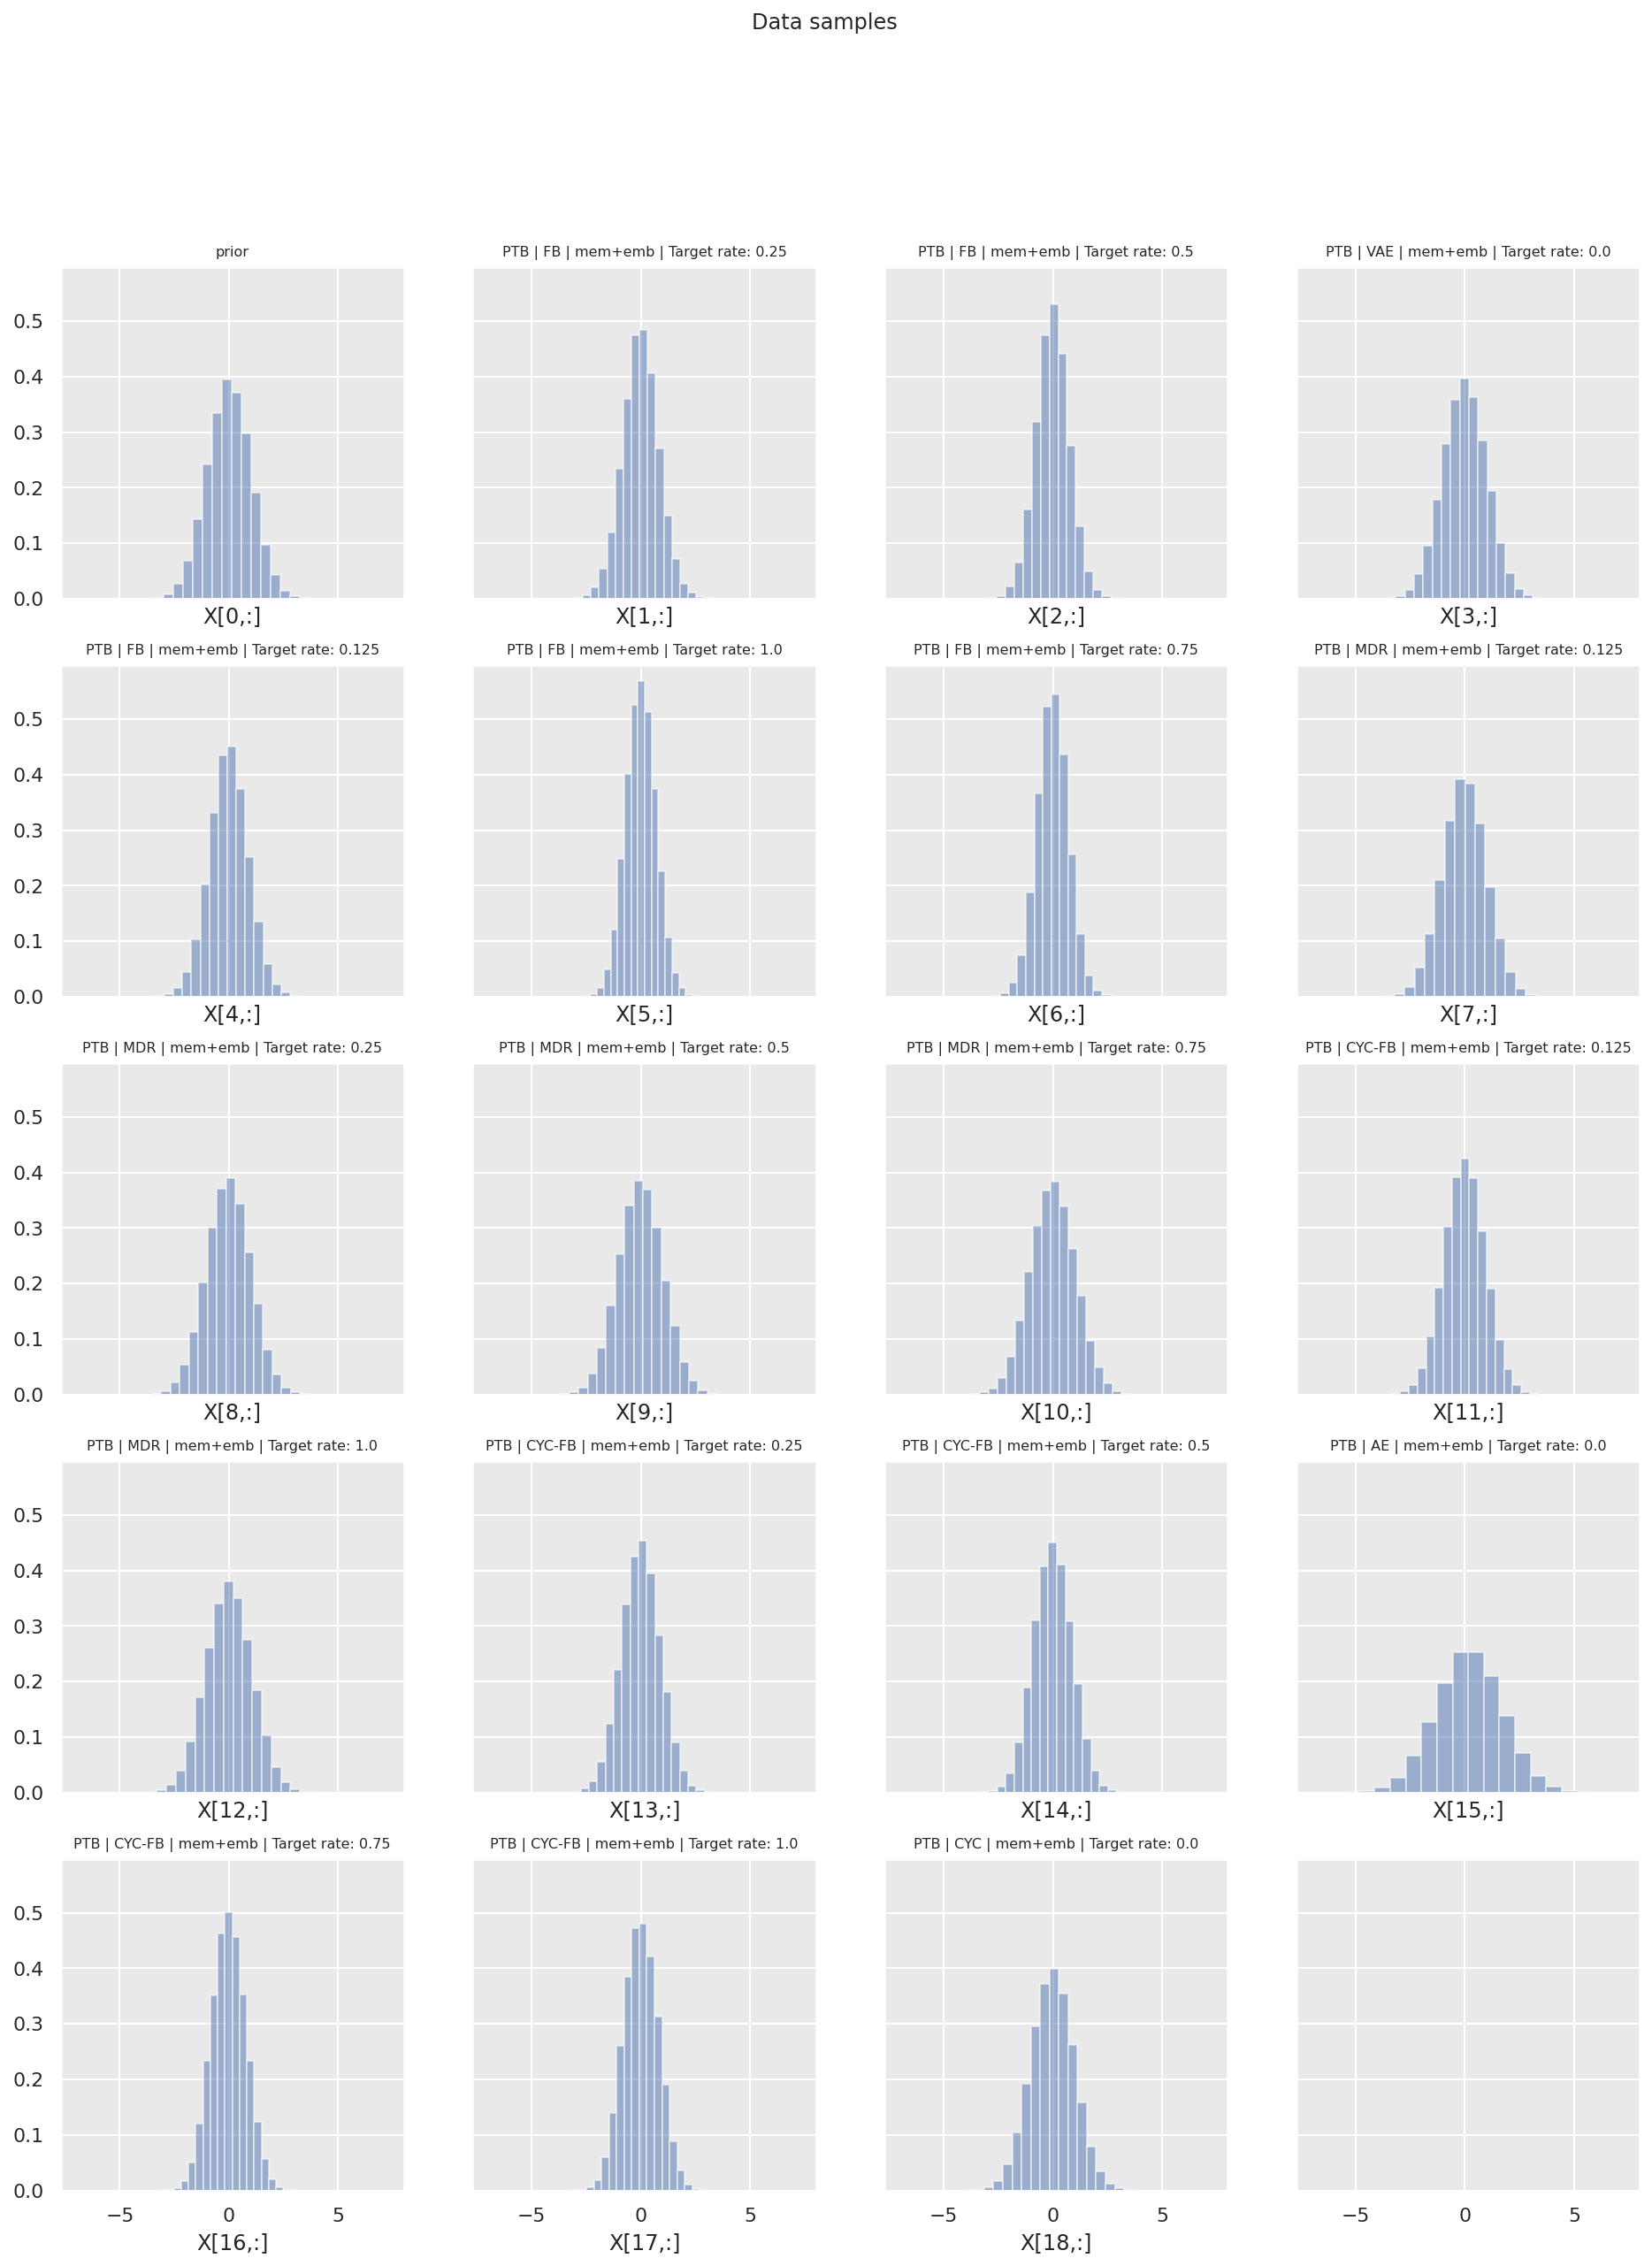

In [11]:
fig, ax = plt.subplots(ncols=4, nrows=G//4+bool(G%4), figsize=(16, 4*(G//4+bool(G%4))), sharex=True, sharey=True)
if len(ax.shape) == 1:
    ax = ax.reshape(1, -1)

for g in range(G):
    _ = ax[g//4, g%4].hist(data[g].flatten().cpu().numpy(), alpha=0.5, density=True, label=f"g={g}", bins=20)
    
    ax[g//4, g%4].set_title(group_names[g], size=8)
    #plt.scatter(data[g,:, 0].cpu().numpy(), data[g,:, 1].cpu().numpy(), alpha=0.3, label=f"{g}")
    _ = ax[g//4, g%4].set_xlabel(f"X[{g},:]")

fig.suptitle(f"Data samples")
plt.savefig("plots/histogram_samples_plot_1d.png", bbox_inches="tight", dpi=300)
fig.show()


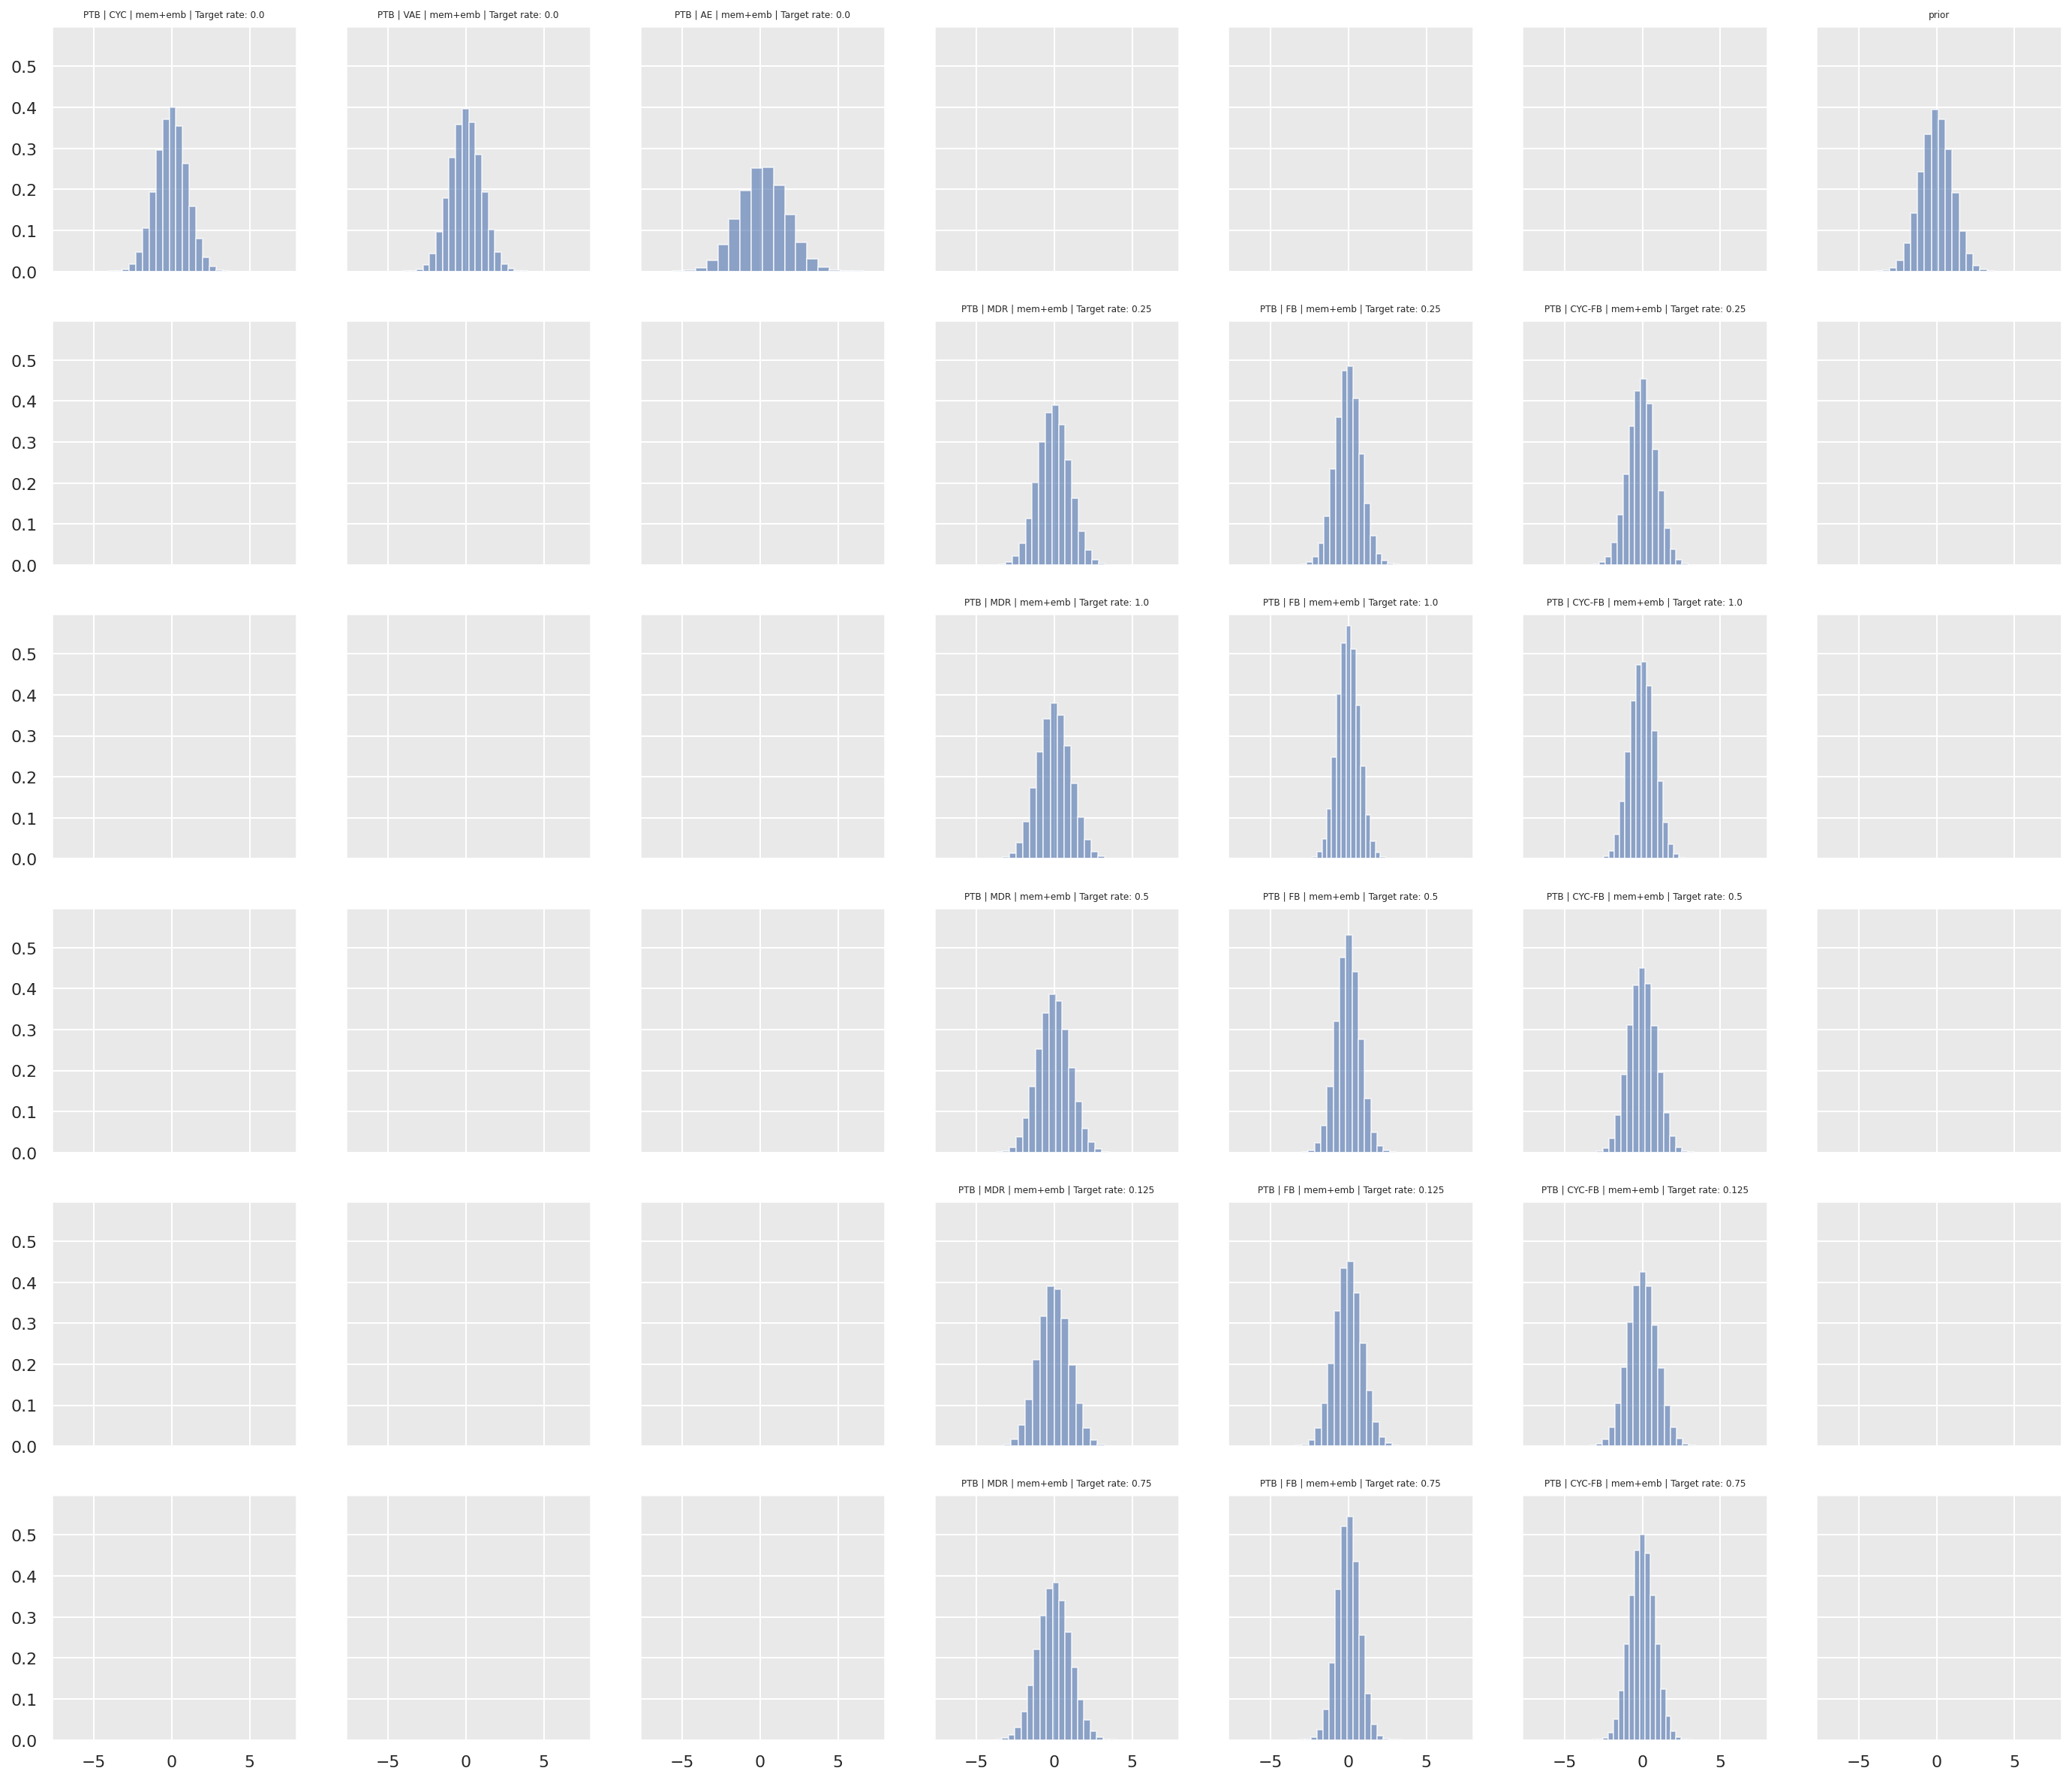

In [12]:
o = list(set(opt_techniques))
tr = list(set(target_rates))

ncols = len(o)
nrows = len(tr)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(nrows*4, ncols*3), sharex=True, sharey=True)

for g in range(G):
    c = o.index(opt_techniques[g])
    r = tr.index(target_rates[g])
    
    axs[r, c].hist(data[g].flatten().cpu().numpy(), alpha=0.6, density=True, bins=20)
    axs[r, c].set_title(group_names[g], size=6)

plt.show()

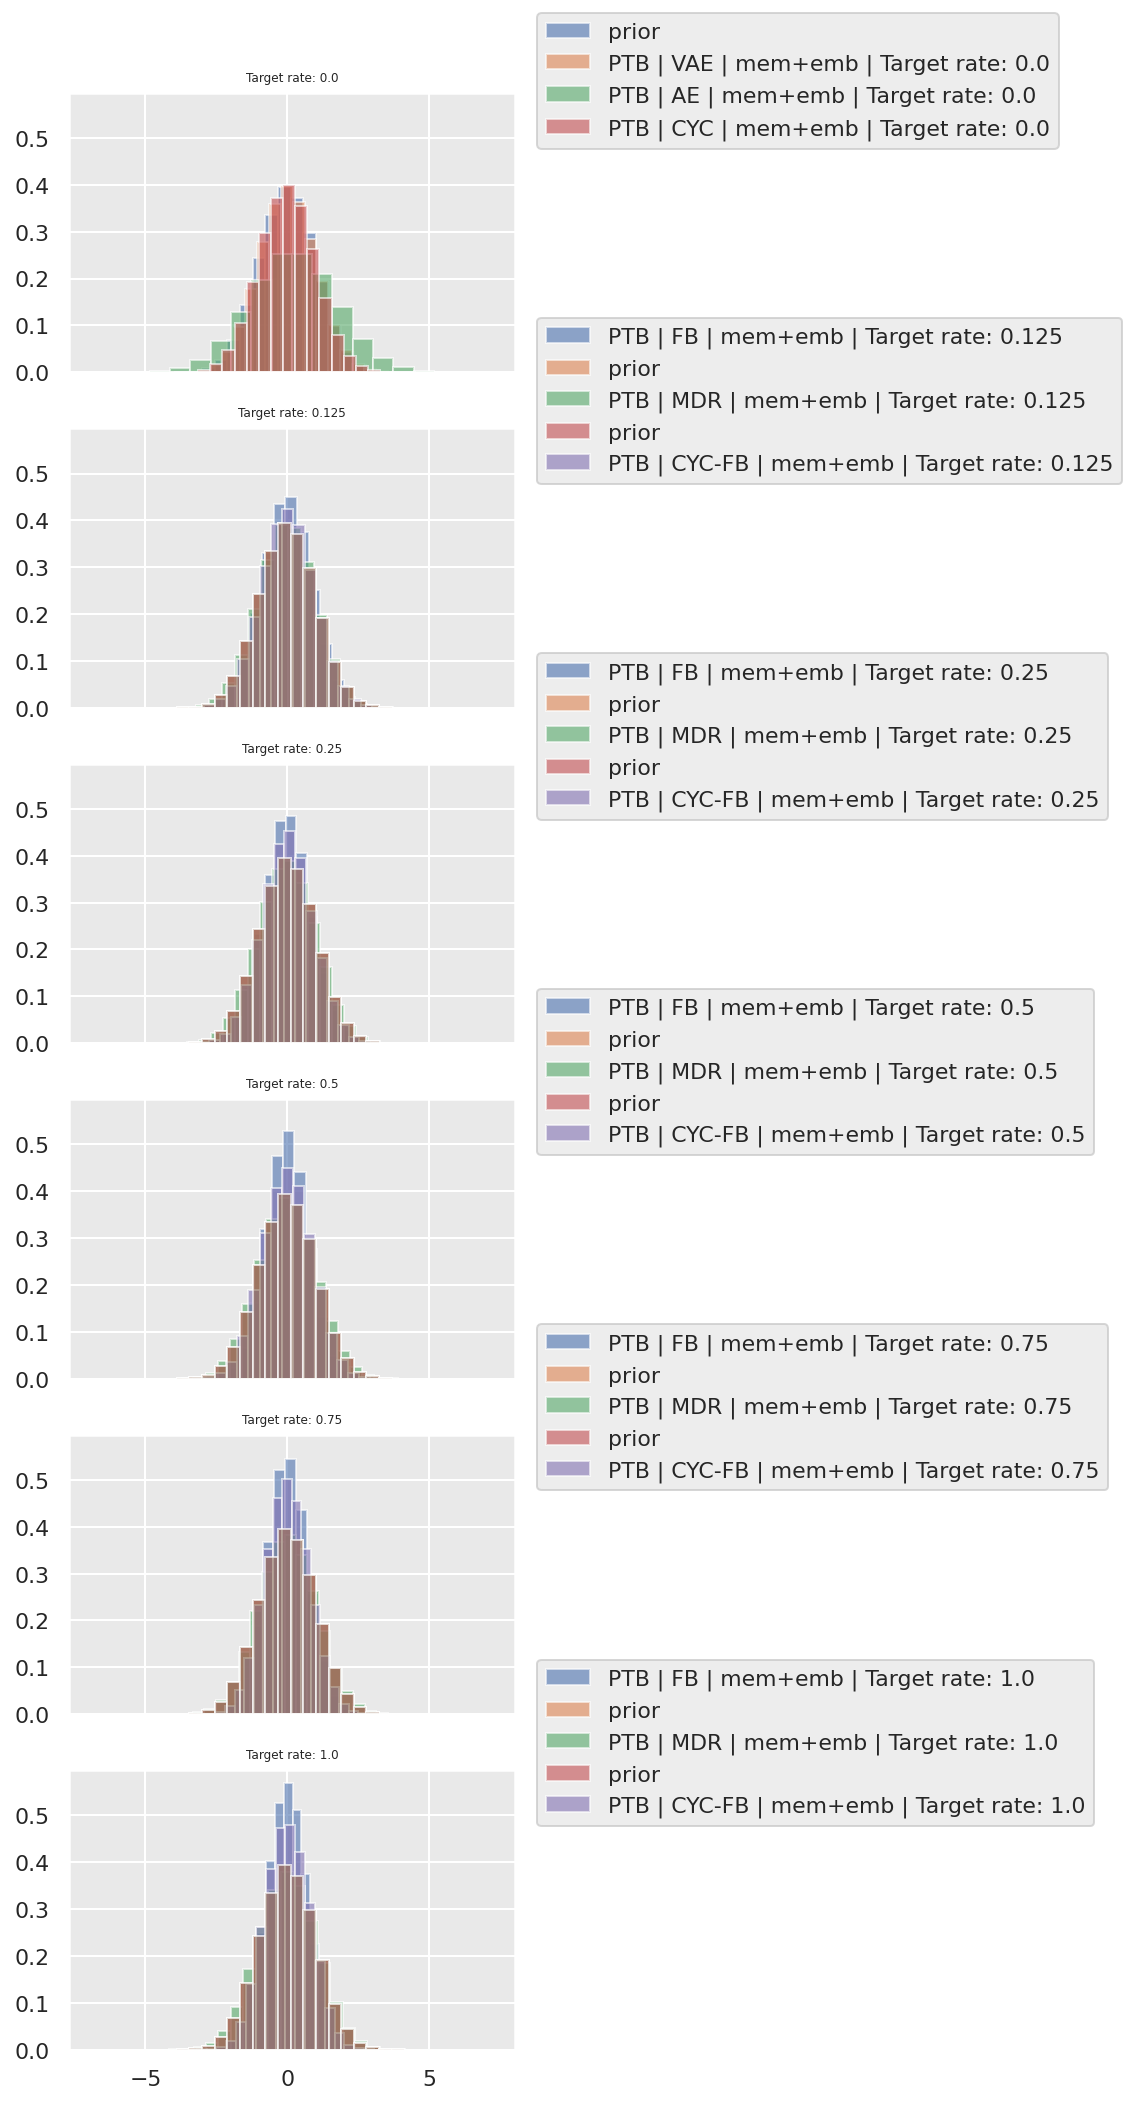

In [13]:
o = list(set(opt_techniques))
tr = sorted(list(set(target_rates)))

ncols = len(o)
nrows = len(tr)

c_dict = {
    ""
}

fig, axs = plt.subplots(ncols=1, nrows=nrows, figsize=(4, nrows*3), sharex=True, sharey=True)

for g in range(G):
    #c = o.index(opt_techniques[g])
    r = tr.index(target_rates[g])
    
    axs[r].hist(data[g].flatten().cpu().numpy(), alpha=0.6, density=True, bins=20, label=group_names[g])
    axs[r].set_title(f"Target rate: {target_rates[g]}", size=6)
    axs[r].legend(loc=(1.05, 0.8))
    
    if target_rates[g] > 0.0:
        axs[r].hist(data[0].flatten().cpu().numpy(), alpha=0.6, density=True, bins=20, label="prior")
        
    
plt.show()

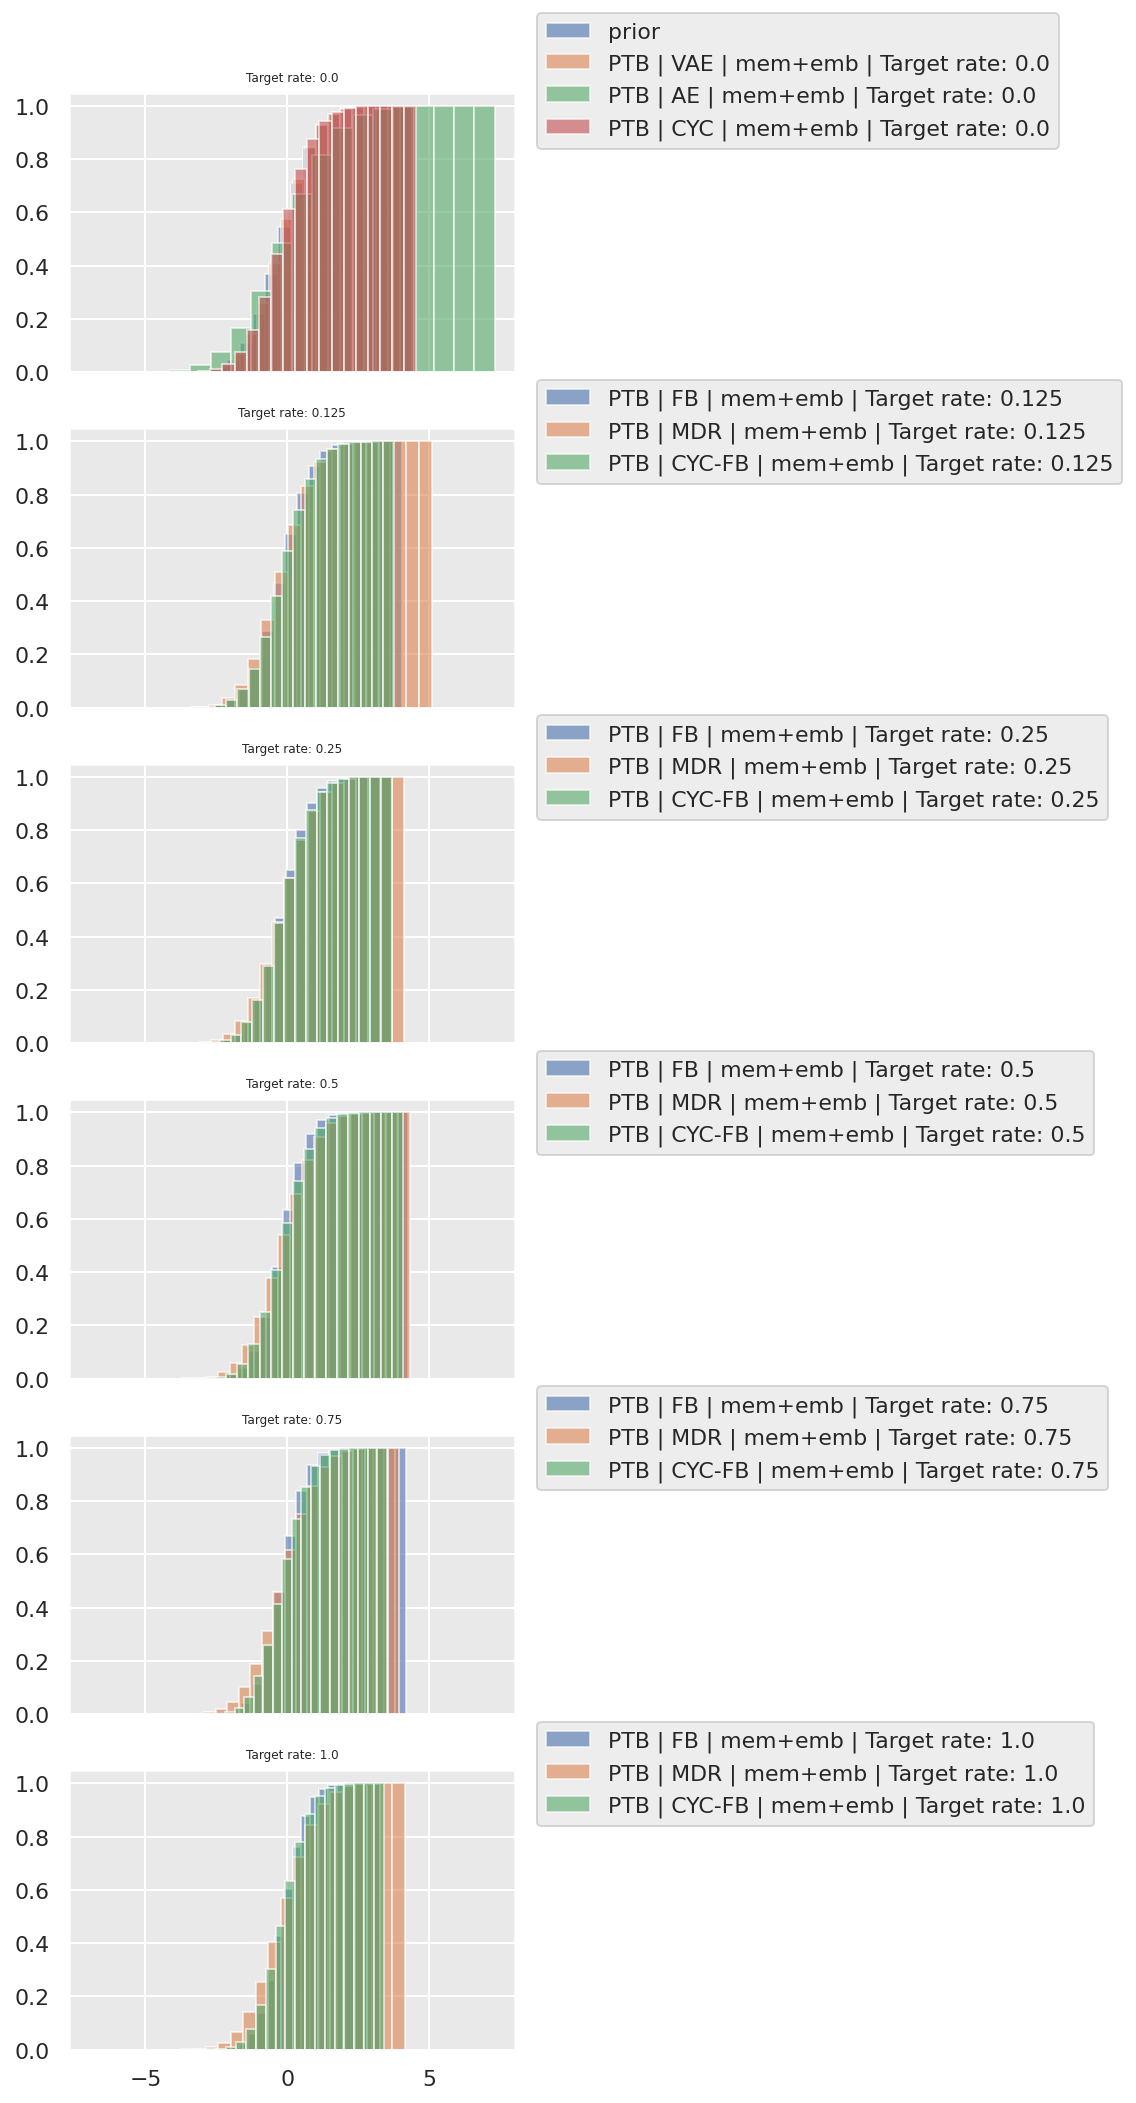

In [14]:
o = list(set(opt_techniques))
tr = sorted(list(set(target_rates)))

ncols = len(o)
nrows = len(tr)

fig, axs = plt.subplots(ncols=1, nrows=nrows, figsize=(4, nrows*3), sharex=True, sharey=True)

for g in range(G):
    #c = o.index(opt_techniques[g])
    r = tr.index(target_rates[g])
    
    axs[r].hist(data[g].flatten().cpu().numpy(), alpha=0.6, density=True, bins=20, label=group_names[g], cumulative=True)
    axs[r].set_title(f"Target rate: {target_rates[g]}", size=6)
    axs[r].legend(loc=(1.05, 0.8))
    
plt.show()

In [15]:
import scipy.stats as st

In [16]:
data.shape

torch.Size([19, 3370, 32])

In [17]:
import torch_two_sample as tts

alpha = 0.05

one_sample_stats = []
two_sample_stats = []
mmd_stats = []

alphas = [0.1 * i for i in range(1, 6)]

MMD = tts.statistics_diff.MMDStatistic(data.shape[1], data.shape[1])

# It's very easy to reject 
for g in range(G):
    # One sample test (against existing, known distribution)
    #print(g, st.kstest(data[g].flatten().cpu().numpy(), 'norm'))
    
    one_sample_ks = st.kstest(data[g].flatten().cpu().numpy(), 'norm')
    
    # Kolmogorov-Smirnov statistic on 2 samples
    two_sample_ks = st.ks_2samp(data[0].flatten().cpu().numpy(), data[g].flatten().cpu().numpy())
    
    mmd = MMD(data[0, :, :], data[g, :, :], alphas=alphas, ret_matrix=False)
    
    mmd_stats.append(mmd.cpu().item())
    one_sample_stats.append(one_sample_ks.statistic)
    two_sample_stats.append(two_sample_ks.statistic)
    
    
    print(f"Assessing '{group_names[g]}' against null of being Normal with Kolmogorov-Smirnov test")
    print(f"One sample KS test statistic: {one_sample_ks.statistic:.2f}, rejecting null {one_sample_ks.pvalue < alpha}")
    print(f"Two sample KS test statistic: {two_sample_ks.statistic:.2f}, rejecting null {two_sample_ks.pvalue < alpha}")
    
    print()
    

Assessing 'prior' against null of being Normal with Kolmogorov-Smirnov test
One sample KS test statistic: 0.00, rejecting null False
Two sample KS test statistic: 0.00, rejecting null False

Assessing 'PTB | FB | mem+emb | Target rate: 0.25' against null of being Normal with Kolmogorov-Smirnov test
One sample KS test statistic: 0.05, rejecting null True
Two sample KS test statistic: 0.05, rejecting null True

Assessing 'PTB | FB | mem+emb | Target rate: 0.5' against null of being Normal with Kolmogorov-Smirnov test
One sample KS test statistic: 0.07, rejecting null True
Two sample KS test statistic: 0.07, rejecting null True

Assessing 'PTB | VAE | mem+emb | Target rate: 0.0' against null of being Normal with Kolmogorov-Smirnov test
One sample KS test statistic: 0.00, rejecting null False
Two sample KS test statistic: 0.00, rejecting null False

Assessing 'PTB | FB | mem+emb | Target rate: 0.125' against null of being Normal with Kolmogorov-Smirnov test
One sample KS test statistic: 0.

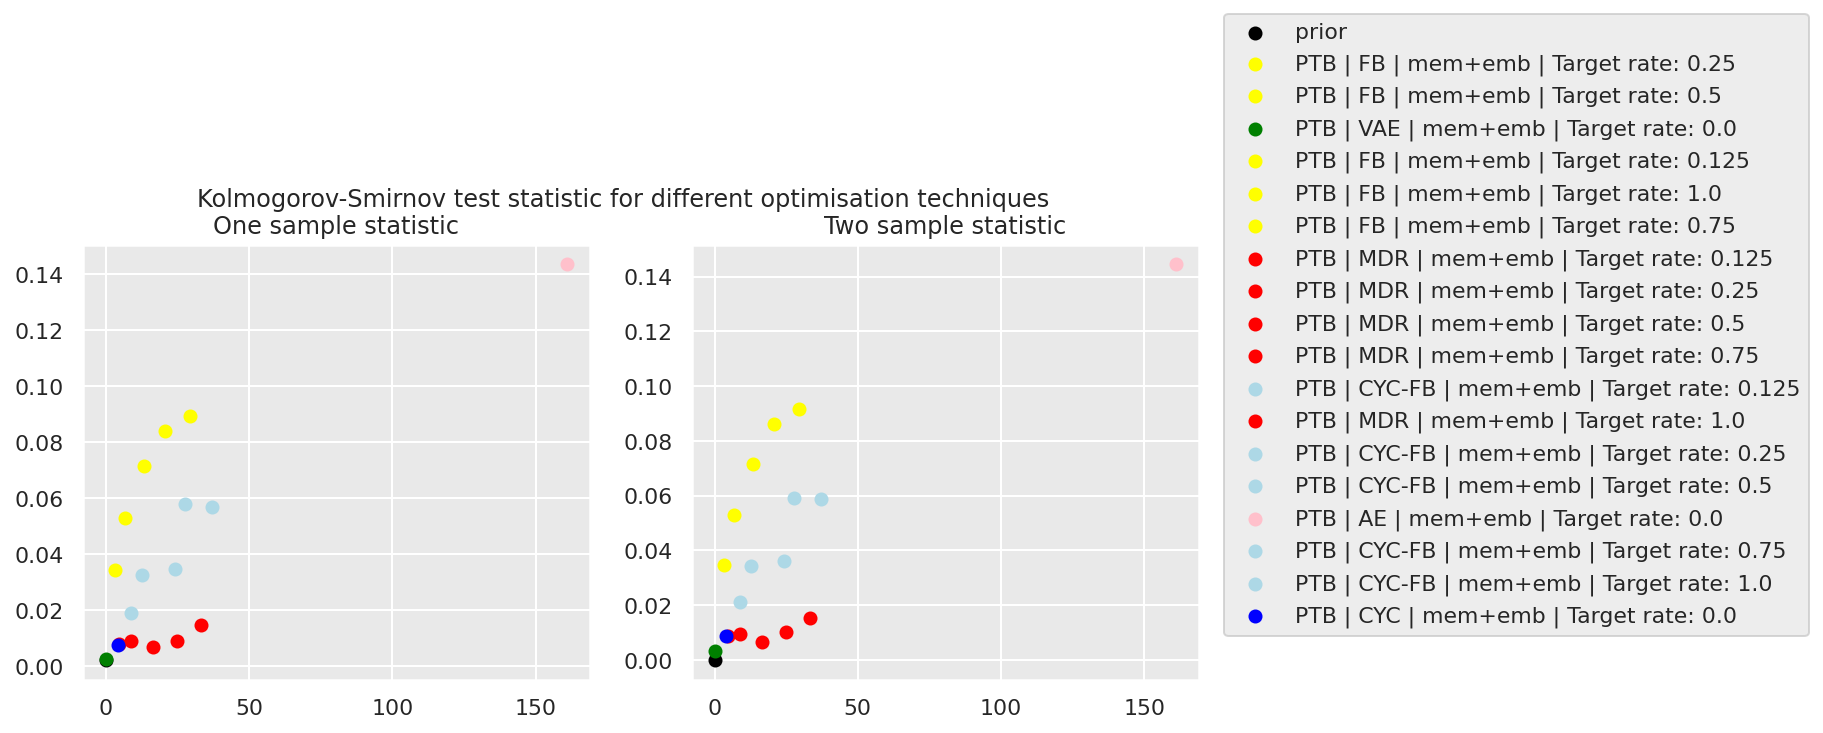

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

colors = ['blue', 'green', 'pink', 'red', 'yellow', 'lightblue', 'black']
c_dict = {o:colors[i] for i, o in enumerate(list(set(opt_techniques)))}

for g in range(G):
    axs[0].scatter(rates[g], one_sample_stats[g], label=group_names[g], color=c_dict[opt_techniques[g]])
axs[0].set_title("One sample statistic")

for g in range(G):
    axs[1].scatter(rates[g], two_sample_stats[g], label=group_names[g], color=c_dict[opt_techniques[g]])
axs[1].set_title("Two sample statistic")

plt.suptitle("Kolmogorov-Smirnov test statistic for different optimisation techniques")
plt.legend(loc=(1.05, 0.1))
plt.show()

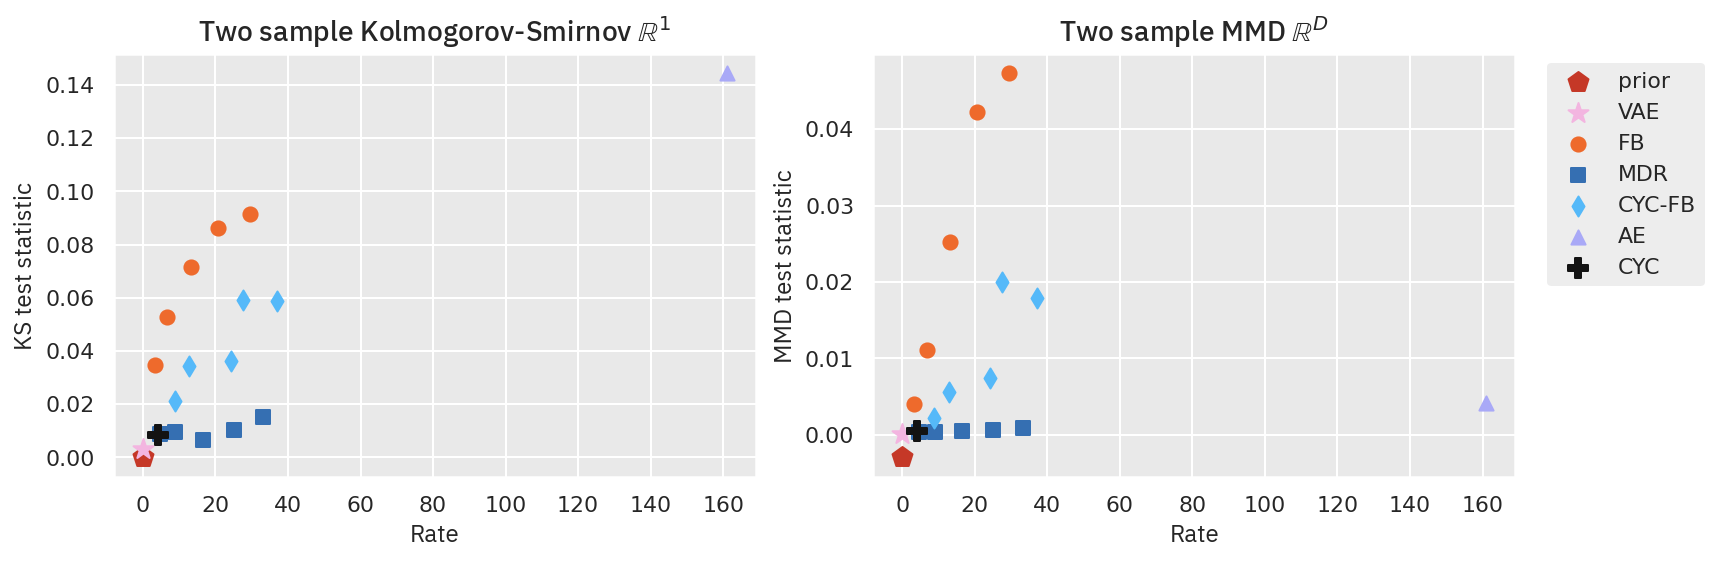

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# for g in range(G):
#     axs[0].scatter(target_rates[g], one_sample_stats[g], label=group_names[g], color=c_dict[opt_techniques[g]])
# axs[0].set_title("One sample statistic")

for g in range(G):
    label = opt_techniques[g] if target_rates[g] < 0.2 else None
    s = 110 if opt_techniques[g] in ["VAE", "CYC", "prior"] else 50
    axs[0].scatter(rates[g], two_sample_stats[g], label=label, color=opt_c_dict[opt_techniques[g]], 
                   marker=marker_dict[opt_techniques[g]], s=s, edgecolors=None)
plt.sca(axs[0])
plt.xticks(fontproperties=get_font_prop("regular"))
plt.yticks(fontproperties=get_font_prop("regular"))
axs[0].set_title(r"Two sample Kolmogorov-Smirnov $\mathbb{R}^1$", fontproperties=get_font_prop("medium"), size=14)
axs[0].set_xlabel("Rate", fontproperties=get_font_prop("regular"), size=12)
axs[0].set_ylabel("KS test statistic", fontproperties=get_font_prop("regular"), size=12)

for g in range(G):
    label = opt_techniques[g] if target_rates[g] < 0.2 else None
    s = 110 if opt_techniques[g] in ["VAE", "CYC", "prior"] else 50
    axs[1].scatter(rates[g], mmd_stats[g], label=label, color=opt_c_dict[opt_techniques[g]],
                  marker=marker_dict[opt_techniques[g]], s=s)

plt.sca(axs[1])
plt.xticks(fontproperties=get_font_prop("regular"))
plt.yticks(fontproperties=get_font_prop("regular"))
axs[1].set_title("Two sample MMD $\mathbb{R}^D$", fontproperties=get_font_prop("medium"), size=14)
axs[1].set_xlabel("Rate", fontproperties=get_font_prop("regular"), size=12)
axs[1].set_ylabel("MMD test statistic", fontproperties=get_font_prop("regular"), size=12)

#plt.suptitle("Kolmogorov-Smirnov test statistic for different optimisation techniques")
leg = plt.legend(loc=(1.05, 0.45))
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()
plt.savefig("plots/ks_mmd.png", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
cfg = OrderedDict(
    T=10, 
    prior_loc=0.0, 
    prior_cov_factor=0.0, 
    prior_cov_diag=1., 
    DP_alpha=1., 
    rank=2,
    device=device
)
cfg = namedtuple("Config", cfg.keys())(*cfg.values())
cfg

Config(T=10, prior_loc=0.0, prior_cov_factor=0.0, prior_cov_diag=1.0, DP_alpha=1.0, rank=2, device=device(type='cuda', index=0))

In [21]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [22]:
#L = td.LKJCholesky(5, 1000).sample()
#L.T @ L

In [23]:
#td.LowRankMultivariateNormal(torch.zeros(3), torch.zeros([3, 3]), torch.ones(3)).covariance_matrix

In [24]:
torch.sort(torch.tensor([[2, 1, 0.5], [0.3, 1., 0.1]]), -1).values

tensor([[0.5000, 1.0000, 2.0000],
        [0.1000, 0.3000, 1.0000]])

In [25]:
@config_enumerate
def model(x):
    """
    covariance_matrix = A.T @ A + diag(B)
    
    Base:
        A[1:D] ~ N(0,1)
        B[1:D] ~ Gamma(10,10) or LogNormal(0,0.1)
        
        
    for t in [T]:
        Dist[t] ~ Base()
    for g in [G]:
        w[g] ~ Stickbreaking(alpha)
        for n in [N[g]]:
            for d in [D]:
                z[g,n,d] ~ Cat(w[g])
                x[g,n,d] ~ Dist[z[g,n]]
    """

    G, S, D = x.shape
    # [S, G, D]
    obs = x.transpose(0, 1)
    assert obs.shape == (S, G, D), f"Got {obs.shape} instead of {(S, G, D)}"
    
    
    # Sample Gaussian Components
    with pyro.plate("components", cfg.T, device=cfg.device):
        # [T, D]
        #prior_loc = torch.full([D], cfg.prior_loc)
        # [T, D, R]
        #prior_cov_factor = cfg.prior_cov_factor + torch.zeros((D, cfg.rank))
        # [T, D]
        #prior_cov_diag = cfg.prior_diag + torch.zeros(D)
        
        mu = pyro.sample("mu", pd.Independent(pd.Normal(torch.zeros(D).to(device), torch.ones(D).to(device)), 1))
        #mu = torch.sort(mu, -1).values
        C = pyro.sample("C", pd.Independent(pd.Normal(torch.zeros(D, cfg.rank).to(device), torch.ones(D, cfg.rank).to(device)), 2))
        diag = pyro.sample("diag", pd.Independent(pd.Gamma(torch.ones(D).to(device)*10., torch.ones(D).to(device)*10), 1))
        
        #mu = pyro.param("mu", td.Normal(torch.zeros(D), torch.ones(D)).sample((cfg.T,)))
        #C = pyro.param("C", td.Normal(torch.zeros(D, cfg.rank), torch.ones(D, cfg.rank)).sample((cfg.T,)))
        #diag = pyro.param("diag", td.LogNormal(torch.zeros(D), torch.ones(D)*0.25).sample((cfg.T,)), constraint=constraints.positive)
        
        # [T, D]
        #mu = pyro.sample("mu", pd.LowRankMultivariateNormal(prior_loc, prior_cov_factor, prior_cov_diag))
        # [T, D]
        #sigma = pyro.sample("sigma", pd.Independent(pd.Gamma(torch.ones(D), torch.ones(D)), 1))
        
    # Sample mixing weights
    with pyro.plate("sticks", cfg.T-1, device=cfg.device):
        with pyro.plate("DPs", G, device=cfg.device):
            # [G, T-1]
            beta = pyro.sample("beta", pd.Beta(torch.ones(1).to(device), cfg.DP_alpha))
            # [G, T]
            omega = pyro.deterministic("omega", mix_weights(beta))

    # Sample observations
    with pyro.plate("group", G, device=cfg.device):
        with pyro.plate("data", S, device=cfg.device):
            # [S, G]
            z = pyro.sample("z", pd.Categorical(probs=omega))

            # [S, G, D]
            loc = mu[z]
            # [S, G, D, D]
            #cov = torch.diag_embed(sigma[z])
            cov_factor = C[z]
            cov_diag = diag[z]

            # mu: [S, G, D]
            pyro.sample("obs", pd.LowRankMultivariateNormal(loc, cov_factor, cov_diag), obs=obs)
            

In [26]:
#trace = poutine.trace(model).get_trace()
trace = poutine.trace(poutine.enum(model, first_available_dim=-3)).get_trace(data)
trace.compute_log_prob()
print(trace.format_shapes())

  Trace Shapes:                     
   Param Sites:                     
  Sample Sites:                     
components dist              |      
          value           10 |      
       log_prob              |      
        mu dist           10 | 32   
          value           10 | 32   
       log_prob           10 |      
         C dist           10 | 32  2
          value           10 | 32  2
       log_prob           10 |      
      diag dist           10 | 32   
          value           10 | 32   
       log_prob           10 |      
    sticks dist              |      
          value            9 |      
       log_prob              |      
       DPs dist              |      
          value           19 |      
       log_prob              |      
      beta dist      19    9 |      
          value      19    9 |      
       log_prob      19    9 |      
     omega dist      19    9 | 19 10
          value              | 19 10
       log_prob      19    9 |      
 

In [27]:
def guide(x):
    G, S, D = x.shape
    
    # [G, T-1]
    kappa = pyro.param('kappa', td.Uniform(0, 2).sample([G, cfg.T-1]).to(device), constraint=constraints.positive)
    
    # [T, D]
    
    m = torch.cat(
        [
            pyro.param('m0', torch.zeros(1, D).to(device)).detach(),
            pyro.param('m', td.Normal(torch.zeros(D), torch.ones(D) * 3).sample([cfg.T - 1]).to(device)),
        ], 0
    )
    #m = torch.sort(m, -1).values
    
    # [T, D]
    #s = torch.stack(
    #    [
    #        pyro.param('m0', torch.ones(D)*0.5413).detach(),
    #        pyro.param('s', td.Normal(torch.zeros(D), torch.ones(D) * 3).sample([cfg.T - 1]))
    #    ]
    #)
    
    # [T, D, R]
    M = torch.cat(
        [
            pyro.param('M0', torch.zeros(1, D, cfg.rank).to(device)).detach(),
            pyro.param('M', td.Normal(torch.zeros(D, cfg.rank), torch.ones(D, cfg.rank) * 3).sample([cfg.T-1]).to(device))
        ], 0
    )
    #S = pyro.param('S', td.Normal(torch.zeros(D, cfg.rank), torch.ones(D, cfg.rank) * 3).sample([cfg.T]))
    
    
    # [T, D]
    #a = pyro.param('a', td.Normal(torch.zeros(D), torch.ones(D)).sample([cfg.T]))
    # [T, D]
    b = torch.cat(
        [
            pyro.param('b0', torch.ones(1, D, device=device)*0.5413).detach(),
            pyro.param('b', td.Normal(torch.ones(D)/2., torch.ones(D)/2.).sample([cfg.T-1]).to(device))
        ], 0
    )

    with pyro.plate("components", cfg.T):
        # [T, D]
        #mu = pyro.sample("mu", pd.Independent(pd.Normal(m, F.softplus(s)), 1))
        #C = pyro.sample("C", pd.Independent(pd.Normal(M, F.softplus(S)), 2) )
        #diag = pyro.sample("diag", pd.Independent(pd.LogNormal(a, F.softplus(b)), 1))
        
        mu = pyro.sample("mu", pd.Independent(pd.Delta(m), 1))
        C = pyro.sample("C", pd.Independent(pd.Delta(M), 2) )
        diag = pyro.sample("diag", pd.Independent(pd.Delta(F.softplus(b)), 1))

    with pyro.plate("sticks", cfg.T-1):
        with pyro.plate("DPs", G):
            # [G, T-1]
            beta = pyro.sample("beta", pd.Beta(torch.ones(1, device=device), kappa))

#     # Sample observations
#     with pyro.plate("group", G):
#         with pyro.plate("data", S):
#             # [S, G]
#             z = pyro.sample("z", pd.Categorical(probs=omega))

In [28]:
#trace = poutine.trace(poutine.enum(guide, first_available_dim=-3)).get_trace(data)
#print(trace.format_shapes())

In [29]:
trace = poutine.trace(guide).get_trace(data)
print(trace.format_shapes())

  Trace Shapes:              
   Param Sites:              
          kappa    19  9     
             m0     1 32     
              m     9 32     
             M0  1 32  2     
              M  9 32  2     
             b0     1 32     
              b     9 32     
  Sample Sites:              
components dist        |     
          value    10  |     
        mu dist    10  | 32  
          value    10  | 32  
         C dist    10  | 32 2
          value    10  | 32 2
      diag dist    10  | 32  
          value    10  | 32  
    sticks dist        |     
          value     9  |     
       DPs dist        |     
          value    19  |     
      beta dist 19  9  |     
          value 19  9  |     


In [30]:
optim = ClippedAdam({"lr": 0.01, "clip_norm": 10.0})
#svi = SVI(model, guide, optim, loss=Trace_ELBO())
elbo = TraceEnum_ELBO(max_plate_nesting=2)
svi = SVI(model, guide, optim, loss=elbo)
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    iterator = tqdm(range(num_iterations))
    for j in iterator:
        loss = svi.step(x=data)
        losses.append(loss)
        iterator.set_postfix(OrderedDict(ELBO=-loss))

In [31]:
train(1000)

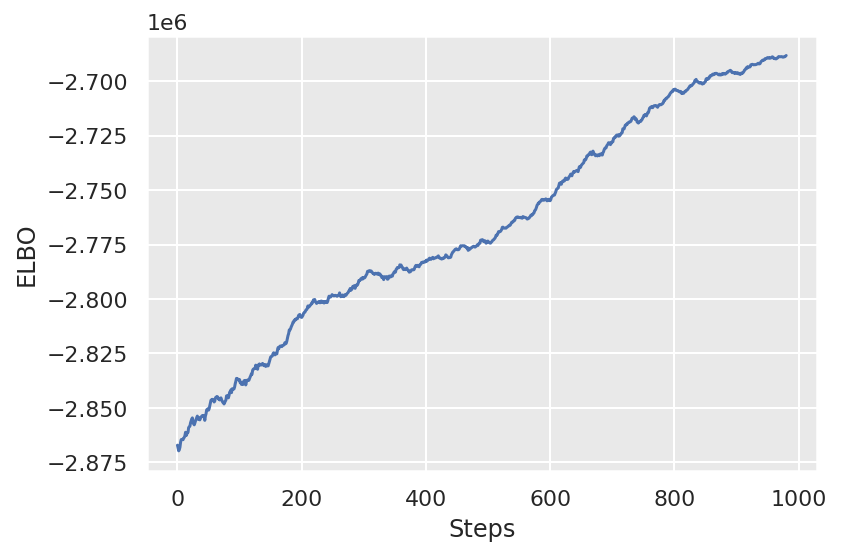

In [32]:
_ = plt.plot(moving_average(-np.array(losses), 20))
_ = plt.xlabel("Steps")
_ = plt.ylabel("ELBO")

In [33]:
# Using pyro's built in posterior predictive class
posterior = Predictive(guide, num_samples=1000)(data)

In [34]:
print(tabulate([[rv, rv_t.shape] for rv, rv_t in posterior.items()]))

----  --------------------------------
mu    torch.Size([1000, 1, 10, 32])
C     torch.Size([1000, 1, 10, 32, 2])
diag  torch.Size([1000, 1, 10, 32])
beta  torch.Size([1000, 19, 9])
----  --------------------------------


In [35]:
components = td.LowRankMultivariateNormal(posterior["mu"], posterior["C"], posterior["diag"])

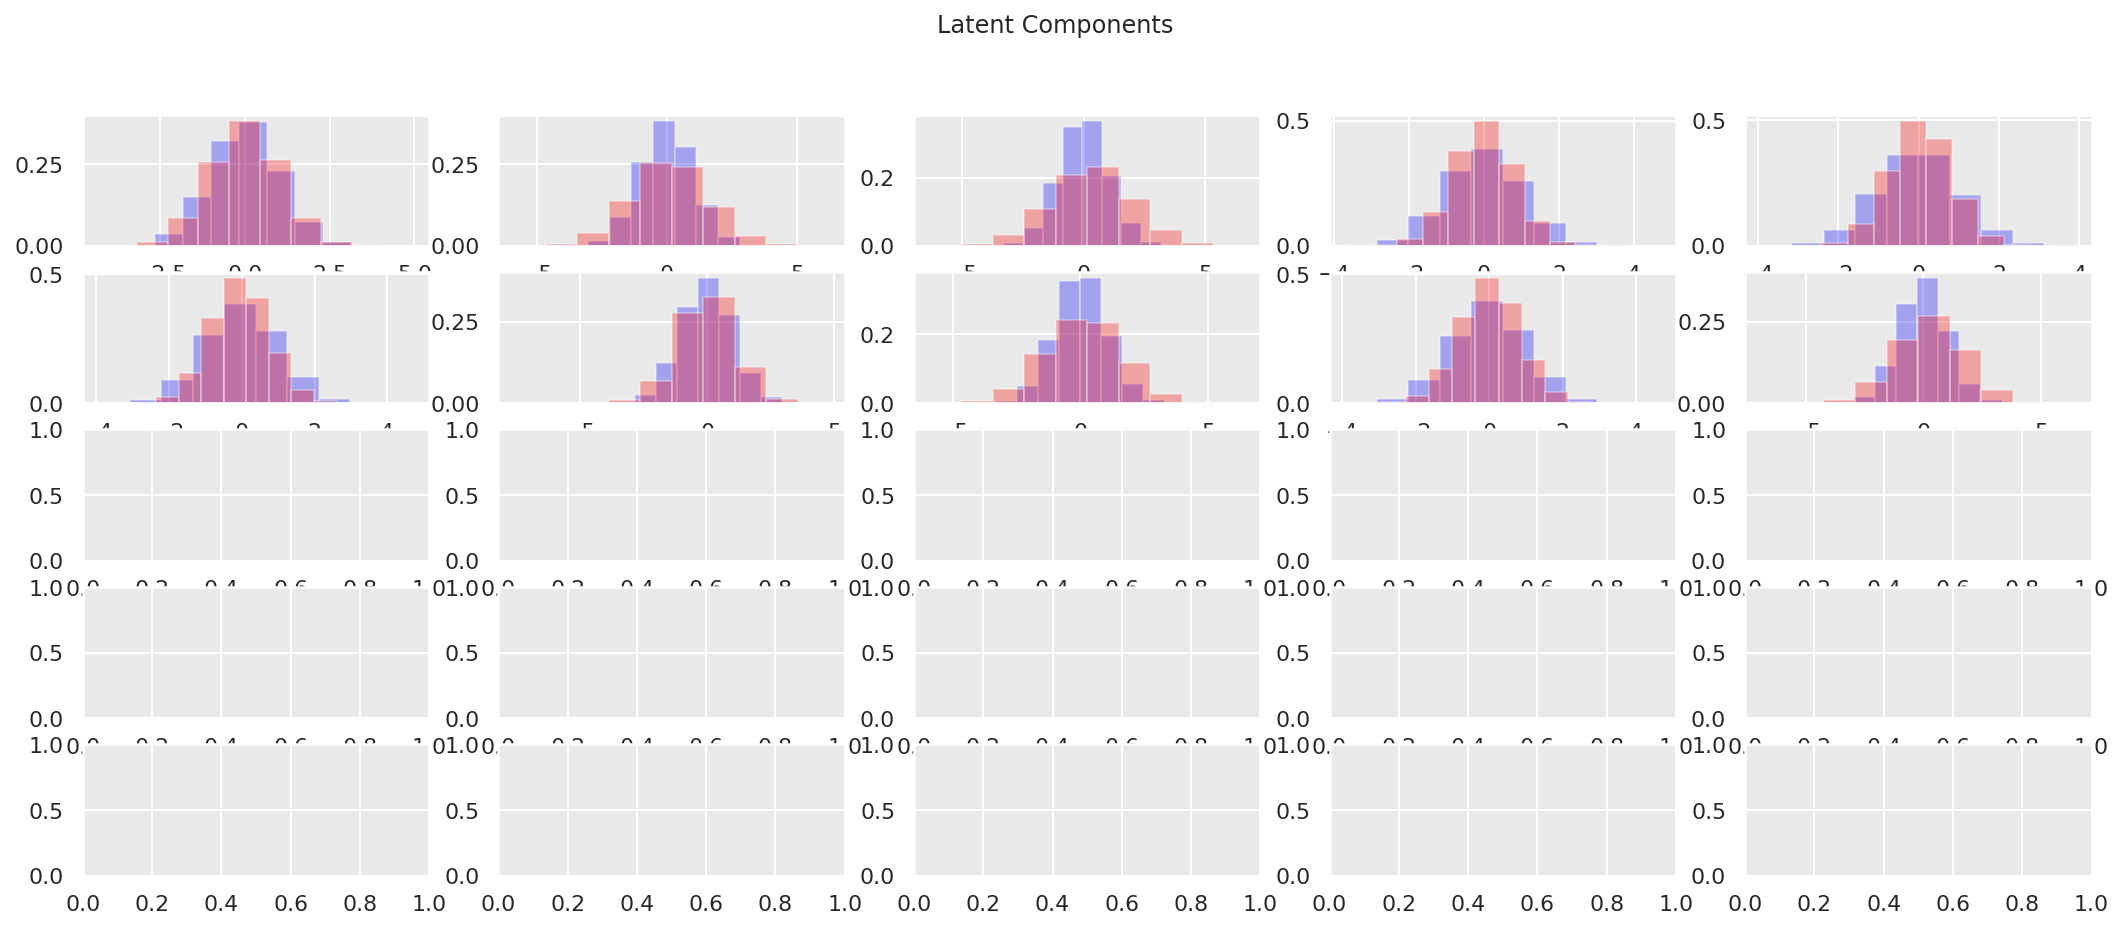

In [36]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(18, 7))

fig.suptitle(f"Latent Components")
fig.show()

for t in range(cfg.T):
    comp = td.LowRankMultivariateNormal(posterior["mu"][:,:,t], posterior["C"][:,:,t], posterior["diag"][:,:,t])
    x_ = comp.sample().detach().cpu().numpy()
    x0 = td.Normal(0, 1).sample(x_.shape).cpu().numpy()
    
    
    _ = ax[t//5, t%5].hist(x0.flatten(), alpha=0.3, density=True, color='blue')
    _ = ax[t//5, t%5].hist(x_.flatten(), alpha=0.3, density=True, color='red')
    _ = ax[t//5, t%5].set_xlabel(f"{t}")    
    
#     _ = plt.plot(x0[...,0], x0[...,1], 's', alpha=0.5, label='prior')
#     _ = plt.plot(x_[...,0], x_[...,1], '.', alpha=0.5, label=f'{t}')
#     _ = plt.legend()
fig.show()

In [37]:
omega = mix_weights(posterior["beta"])
omega.shape

torch.Size([1000, 19, 10])

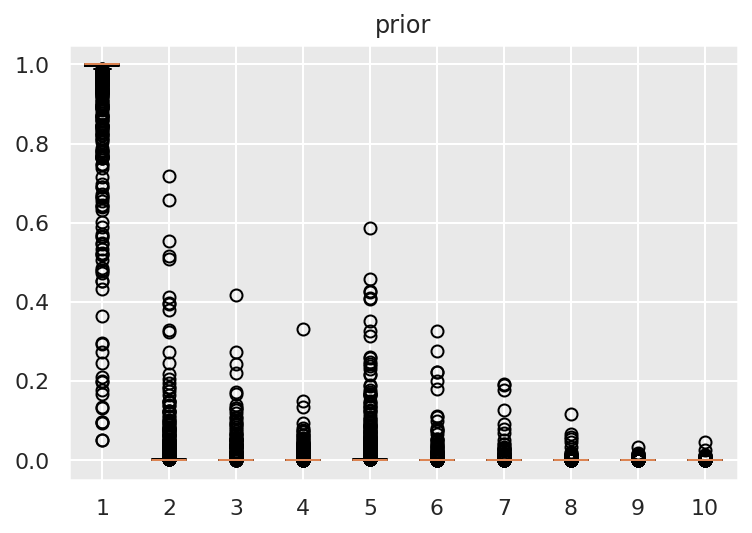

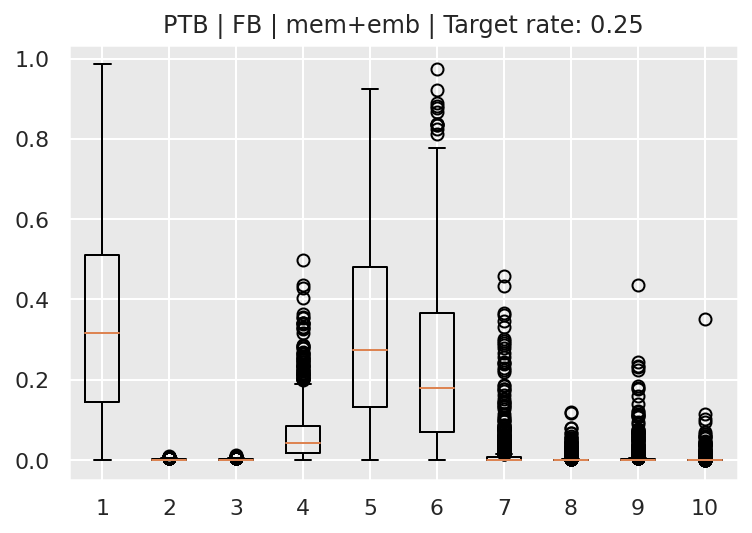

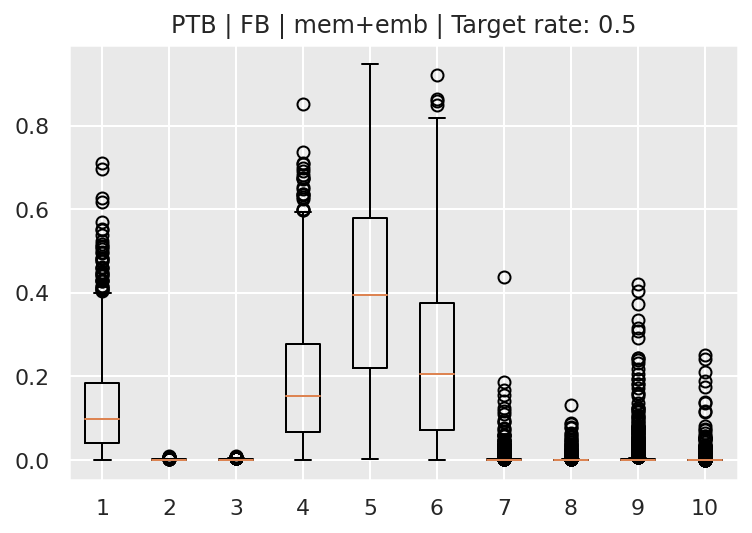

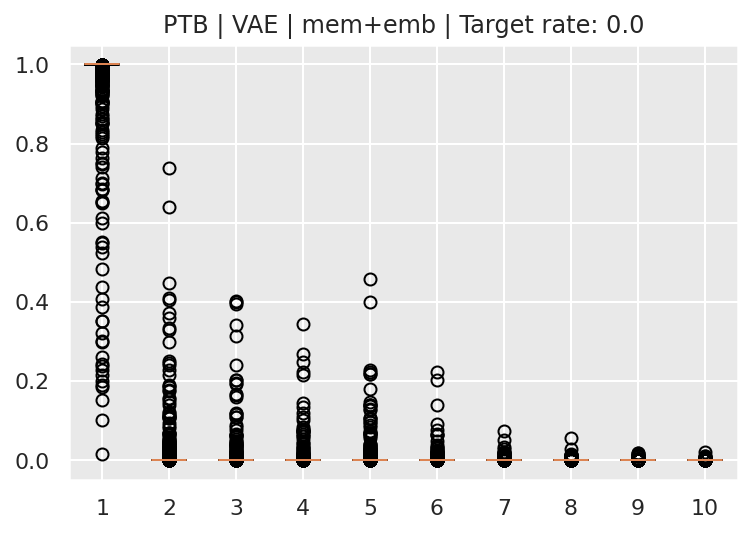

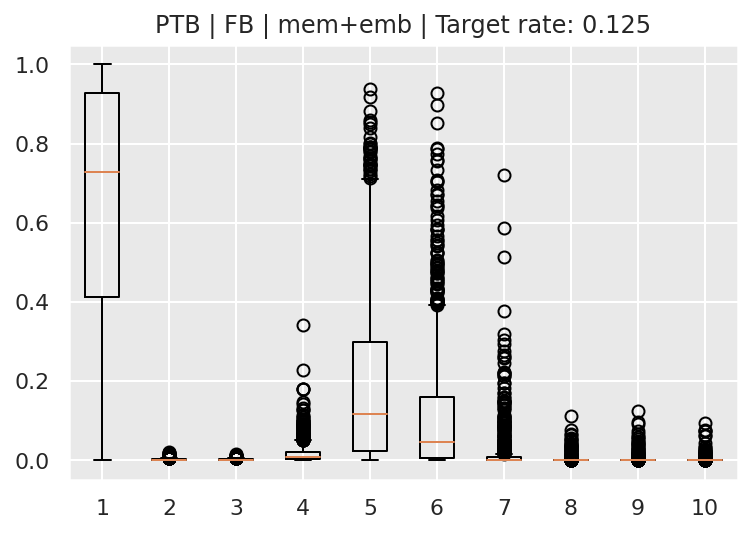

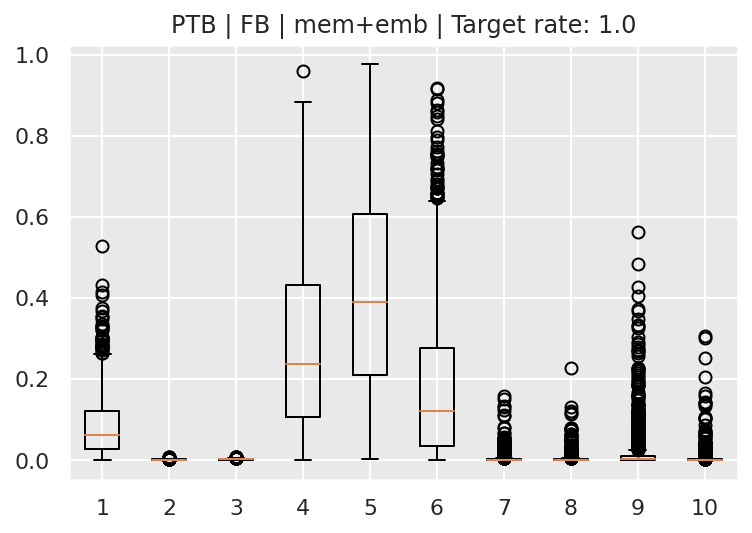

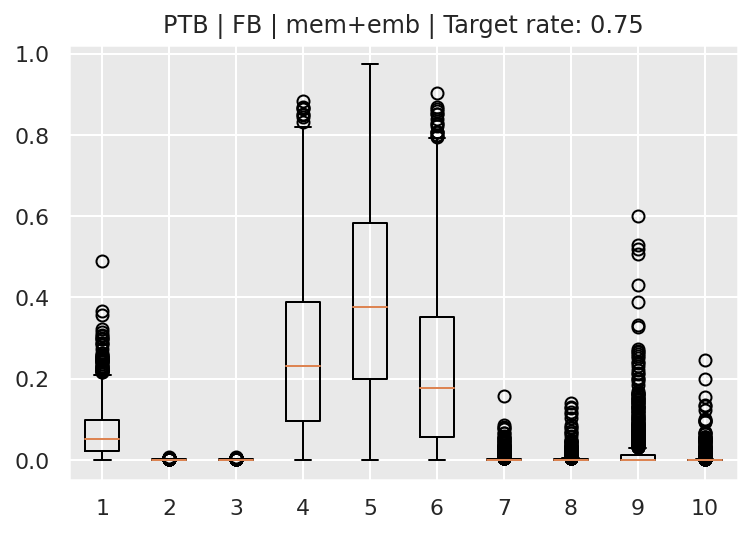

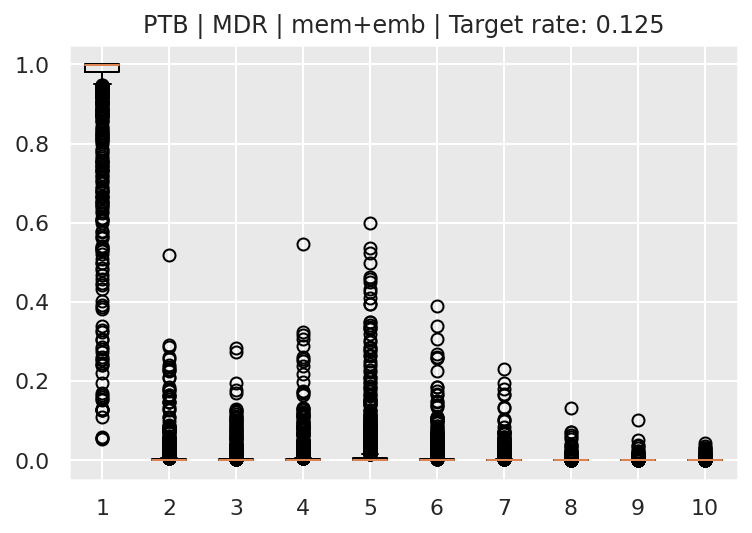

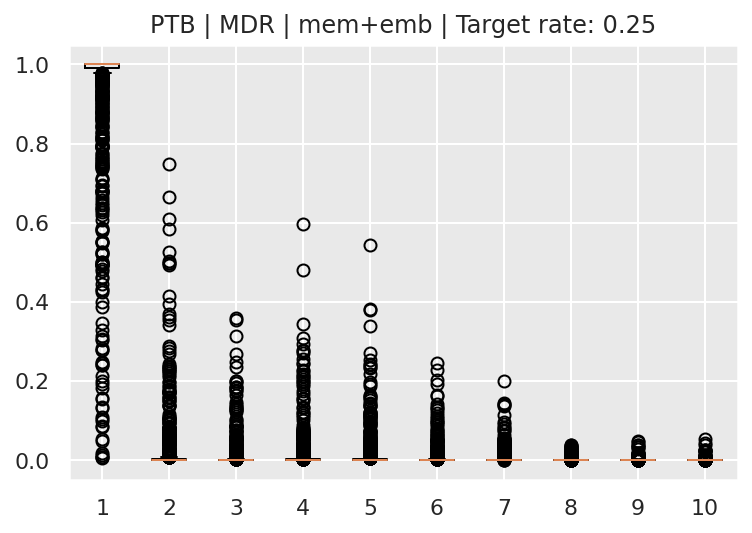

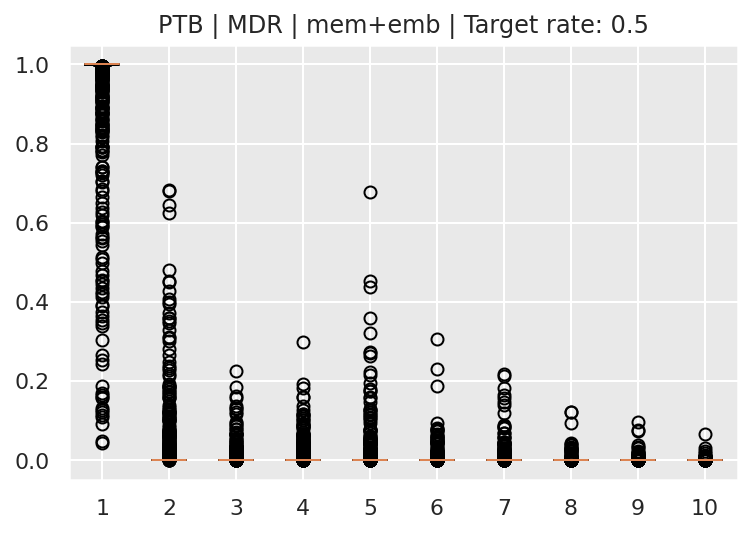

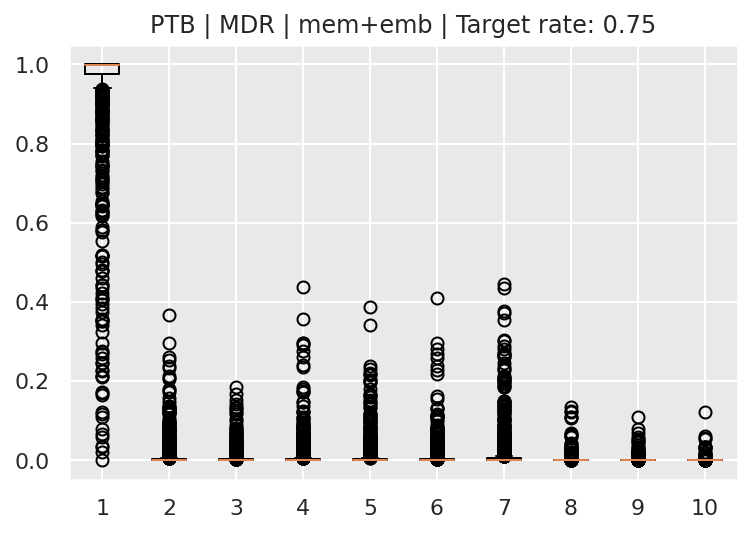

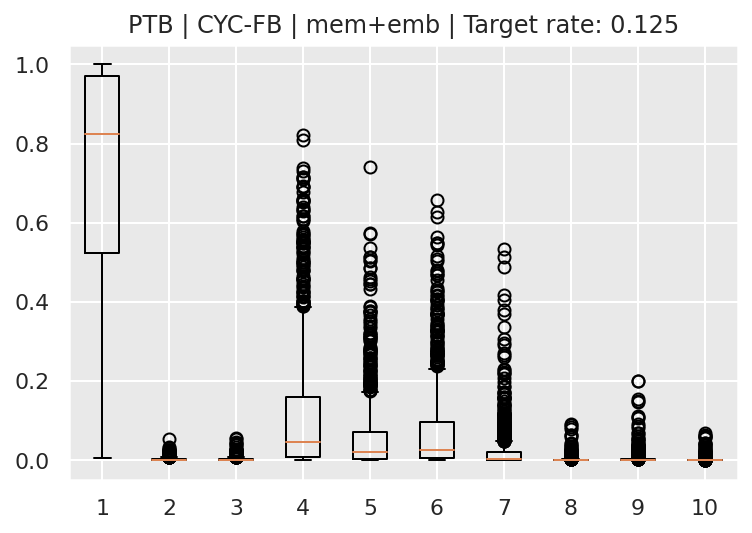

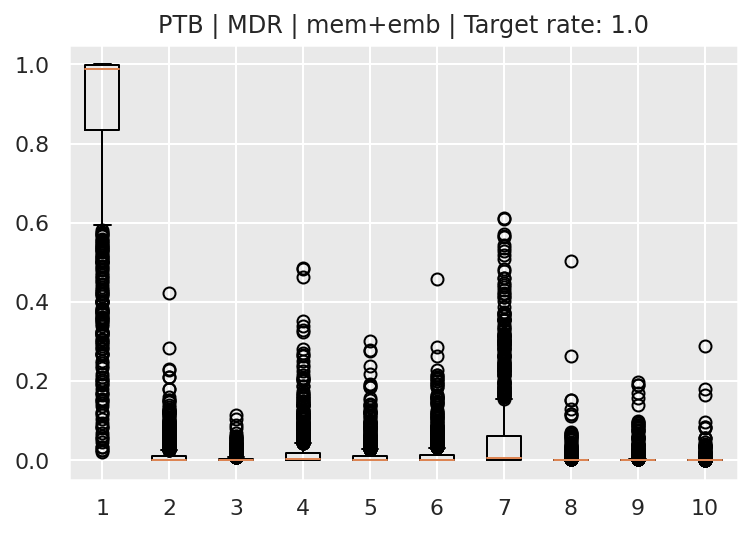

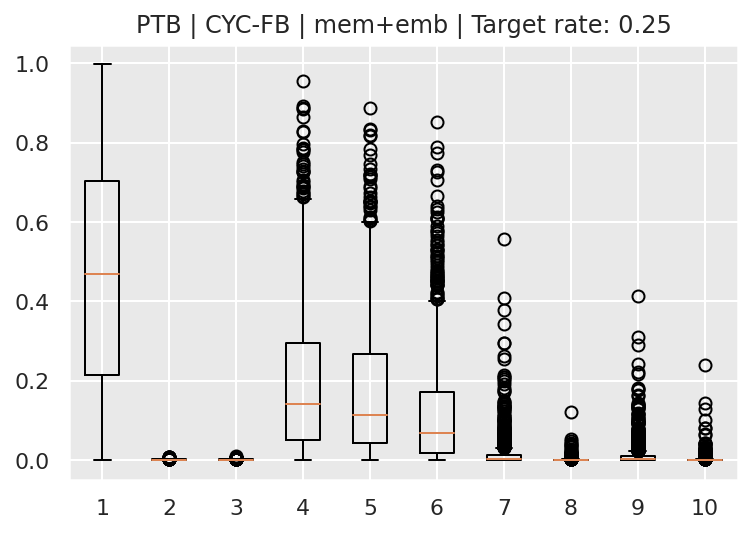

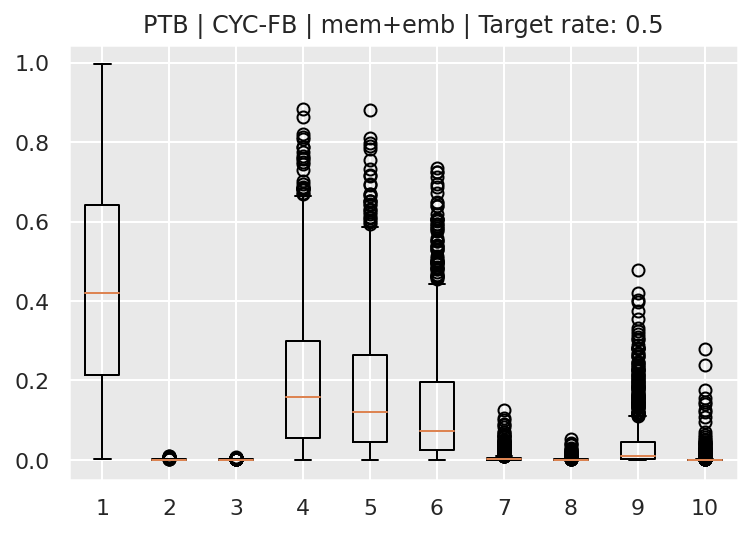

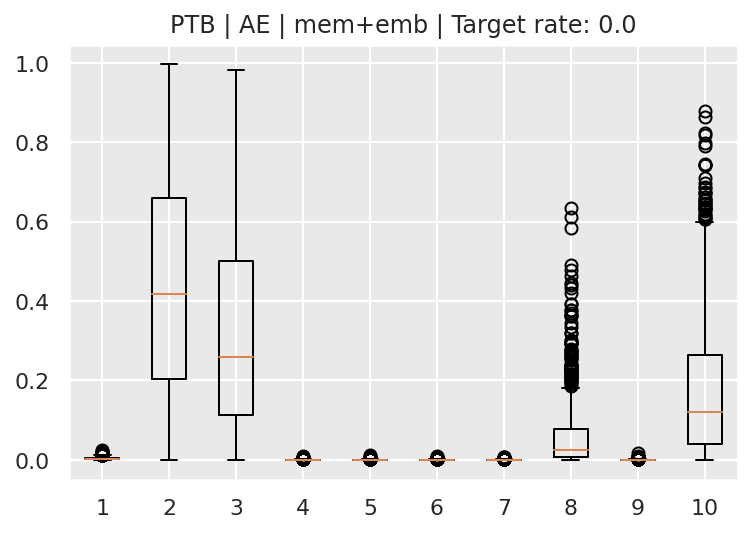

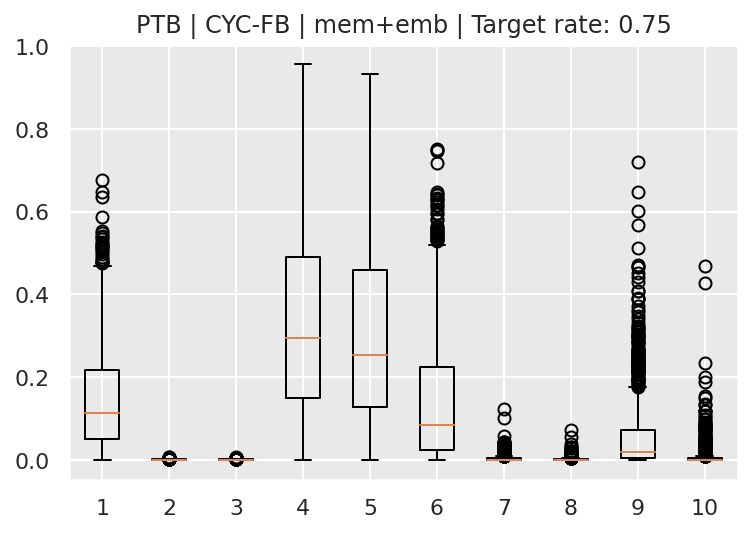

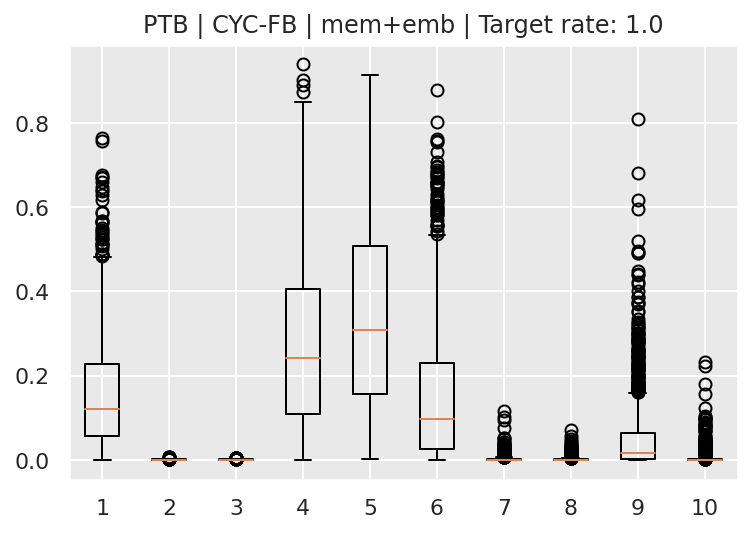

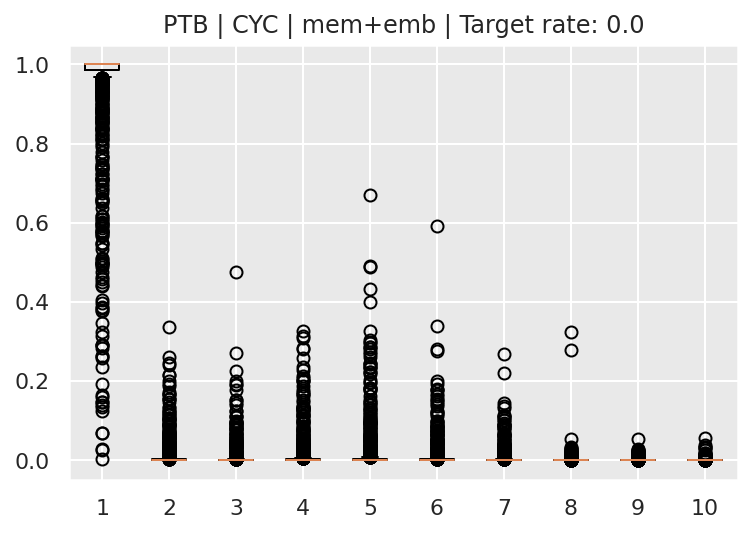

In [38]:
for g in range(G):
    plt.title(group_names[g])
    _ = plt.boxplot(omega[:,g,:].detach().cpu().numpy())
    plt.show()

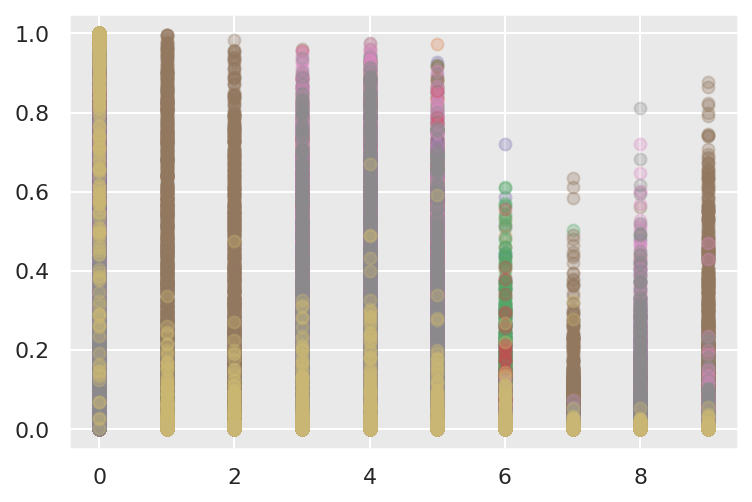

In [39]:
for g in range(G):
    _ = plt.plot(
        torch.arange(cfg.T).expand(omega.shape).detach().cpu().numpy()[:,g,:].flatten(),
        omega.detach().cpu().numpy()[:,g,:].flatten(),
        'o',
        alpha=0.3
    )
plt.show()    

In [40]:
group_names_ordered = [
 'prior',
 'PTB | VAE | mem+emb | Target rate: 0.0',
 'PTB | AE | mem+emb | Target rate: 0.0',
 'PTB | CYC | mem+emb | Target rate: 0.0',
 'PTB | FB | mem+emb | Target rate: 0.125',
 'PTB | FB | mem+emb | Target rate: 0.25',
 'PTB | FB | mem+emb | Target rate: 0.5',
 'PTB | FB | mem+emb | Target rate: 0.75',
 'PTB | FB | mem+emb | Target rate: 1.0',
 'PTB | MDR | mem+emb | Target rate: 0.125',
 'PTB | MDR | mem+emb | Target rate: 0.25',
 'PTB | MDR | mem+emb | Target rate: 0.5',
 'PTB | MDR | mem+emb | Target rate: 0.75',
 'PTB | MDR | mem+emb | Target rate: 1.0',
 'PTB | CYC-FB | mem+emb | Target rate: 0.125',
 'PTB | CYC-FB | mem+emb | Target rate: 0.25',
 'PTB | CYC-FB | mem+emb | Target rate: 0.5',
 'PTB | CYC-FB | mem+emb | Target rate: 0.75',
 'PTB | CYC-FB | mem+emb | Target rate: 1.0']

group_names_ordered_clean_names = [
 'Prior',
 'VAE',
 'AE',
 'CYC',
 'FB - tr: 0.13',
 '         tr: 0.25',
 '         tr: 0.50',
 '         tr: 0.75',
 '         tr: 1.00',
 'MDR - tr: 0.13',
 '         tr: 0.25',
 '         tr: 0.50',
 '         tr: 0.75',
 '         tr: 1.00',
 'CYC-FB - tr: 0.13',
 '         tr: 0.25',
 '         tr: 0.50',
 '         tr: 0.75',
 '         tr: 1.00']

len(group_names_ordered_clean_names), len(group_names_ordered)

(19, 19)

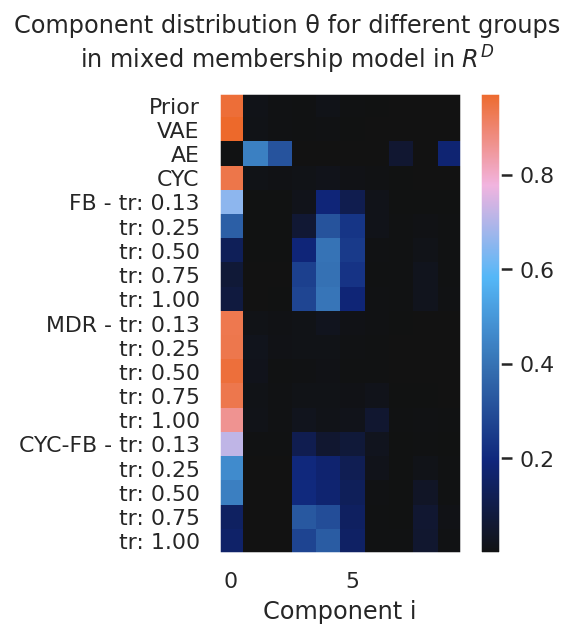

In [41]:
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

omega_avg = omega.mean(0).detach().cpu().numpy()

omega_ordered = []
for gn in group_names_ordered:
    old_idx = group_names.index(gn)
    omega_ordered.append(omega_avg[old_idx, :])

omega_ordered = np.stack(omega_ordered)

fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(4, 4))
im = axs[0].imshow(omega_ordered, cmap=cmap)

axs[0].set_yticks(range(G))
axs[0].set_yticklabels(group_names_ordered_clean_names)
axs[0].set_xlabel("Component i")

plt.colorbar(im, cax=axs[1])
plt.tight_layout()
plt.suptitle("Component distribution θ for different groups\nin mixed membership model in $R^D$", y=1.1)
#plt.axis('off')
plt.savefig("plots/MMM_RD_component_plot.png", dpi=300, bbox_inches="tight")
plt.show()

# Use the group mixtures to estimate log q z

In [42]:
import math

def sample_log_likelihood(latent_z, mu=None, logvar=None, reduce_latent_dim=True, reduce_batch_dim=True):
    """
    This function calculates the log likelihood of samples under the Normal
    Distribution, either parameterised by mu, logvar (posterior), else under the standard Normal (prior).
    """

    # Multi sample posterior case
    if latent_z.dim() == 3 and mu is not None and logvar is not None:
        if mu.dim() != 3:
            mu = mu.unsqueeze(1)
        if logvar.dim() != 3:
            logvar = logvar.unsqueeze(1)

    # Under a posterior z under q(z|x)
    if logvar is not None and mu is not None:
        # N(z| mu, sigma) = [-1 / 2(log var + log 2pi + (x - mu) ^ 2 / var)]
        var = logvar.exp()
        likelihood = (- 0.5 * (logvar + math.log(2 * math.pi) + ((latent_z - mu) ** 2 / var)))

    # Under a prior
    else:
        # N(z | 0, 1) = [-1/2 ( log 2pi + x^2)]
        likelihood = - 0.5 * (math.log(2 * math.pi) + (latent_z ** 2))

    # Reduce the latent dimension (log sum)
    if reduce_latent_dim:
        likelihood = likelihood.sum(dim=-1)

    if reduce_batch_dim:
        likelihood = likelihood.mean(dim=0)

    return likelihood

In [43]:
# # Construct Gaussian Mixture Modle in 2D consisting of 5 equally
# # weighted bivariate normal distributions
# >>> mix = D.Categorical(torch.ones(5,))
# >>> comp = D.Independent(D.Normal(
#              torch.randn(5,2), torch.rand(5,2)), 1)
# >>> gmm = MixtureSameFamily(mix, comp)

# # Construct a batch of 3 Gaussian Mixture Models in 2D each
# # consisting of 5 random weighted bivariate normal distributions
# >>> mix = D.Categorical(torch.rand(3,5))
# >>> comp = D.Independent(D.Normal(
#             torch.randn(3,5,2), torch.rand(3,5,2)), 1)
# >>> gmm = MixtureSameFamily(mix, comp)

In [44]:
omega.shape, posterior["mu"].shape, posterior["C"].shape, posterior["diag"].shape

(torch.Size([1000, 19, 10]),
 torch.Size([1000, 1, 10, 32]),
 torch.Size([1000, 1, 10, 32, 2]),
 torch.Size([1000, 1, 10, 32]))

In [46]:
import torch.distributions as t_dist

estimates = {}

# For all groups
for g in range(G):
    group_name = group_names[g]
    print(f"{g+1}/{G} - {group_name}")
    tr = target_rates[g]
    opt = opt_techniques[g]
    
    # Get latent data for this group, generate for the prior group
    if group_name != "prior":
        group_encodings = all_encodings[group_name]
        mus = torch.FloatTensor(group_encodings["mus"])
        logvars = torch.FloatTensor(group_encodings["logvars"])
        group_latents = torch.FloatTensor(group_encodings["latents"])
    else:
        mus = torch.zeros((3370, 32))
        stds = torch.ones((3370, 32))
        logvars = torch.zeros((3370, 32))
        group_latents = torch.randn((3370, 32))
    
    # for all samples mu, c, diag: create the actual mixture and evaluate the latent_samples under it
    
    # omega [S, G, T]
    # batch of 1000 mixtures all of 10 components
    mix = t_dist.Categorical((omega[:, g, :].cpu()))
    
    mu = posterior["mu"].squeeze(1).cpu()
    C = posterior["C"].squeeze(1).cpu()
    diag = posterior["diag"].squeeze(1).cpu()
    
    #print(mu.device, C.device, group_latents.device, diag.device, omega.device)
    
    comp = td.LowRankMultivariateNormal(mu,  C, diag)
    batched_mixture = t_dist.mixture_same_family.MixtureSameFamily(mix, comp)
    
    # this returns log_q_z of all latents under all sampled mixtures in of the posterior of the group
    # [NUM_LATENTS, S]
    log_q_z = batched_mixture.log_prob(group_latents.unsqueeze(1))
    
    # average over posterior samples
    log_q_z_mean = log_q_z.mean()
    
    # also calculate the likelihood under the posteriors and priors
    log_q_z_x = sample_log_likelihood(group_latents, mu=mus, logvar=logvars)
    log_p_z = sample_log_likelihood(group_latents)
    
    # rate, marginal KL and IC-MI
    rate = log_q_z_x - log_q_z_mean
    marginal_kl = log_q_z_mean - log_p_z
    index_code_mi = rate - marginal_kl
    
    # store results
    estimates[group_name] = {
        "log_q_z": log_q_z_mean.item(),
        "log_p_z": log_p_z.item(),
        "log_q_z_x": log_q_z_x.item(),
        "rate": rate.item(),
        "optimisation": opt,
        "marginal_kl": marginal_kl.item(),
        "index_code_mi": index_code_mi,
        "target_rate": tr,
    }

1/19 - prior
2/19 - PTB | FB | mem+emb | Target rate: 0.25
3/19 - PTB | FB | mem+emb | Target rate: 0.5
4/19 - PTB | VAE | mem+emb | Target rate: 0.0
5/19 - PTB | FB | mem+emb | Target rate: 0.125
6/19 - PTB | FB | mem+emb | Target rate: 1.0
7/19 - PTB | FB | mem+emb | Target rate: 0.75
8/19 - PTB | MDR | mem+emb | Target rate: 0.125
9/19 - PTB | MDR | mem+emb | Target rate: 0.25
10/19 - PTB | MDR | mem+emb | Target rate: 0.5
11/19 - PTB | MDR | mem+emb | Target rate: 0.75
12/19 - PTB | CYC-FB | mem+emb | Target rate: 0.125
13/19 - PTB | MDR | mem+emb | Target rate: 1.0
14/19 - PTB | CYC-FB | mem+emb | Target rate: 0.25
15/19 - PTB | CYC-FB | mem+emb | Target rate: 0.5
16/19 - PTB | AE | mem+emb | Target rate: 0.0
17/19 - PTB | CYC-FB | mem+emb | Target rate: 0.75
18/19 - PTB | CYC-FB | mem+emb | Target rate: 1.0
19/19 - PTB | CYC | mem+emb | Target rate: 0.0


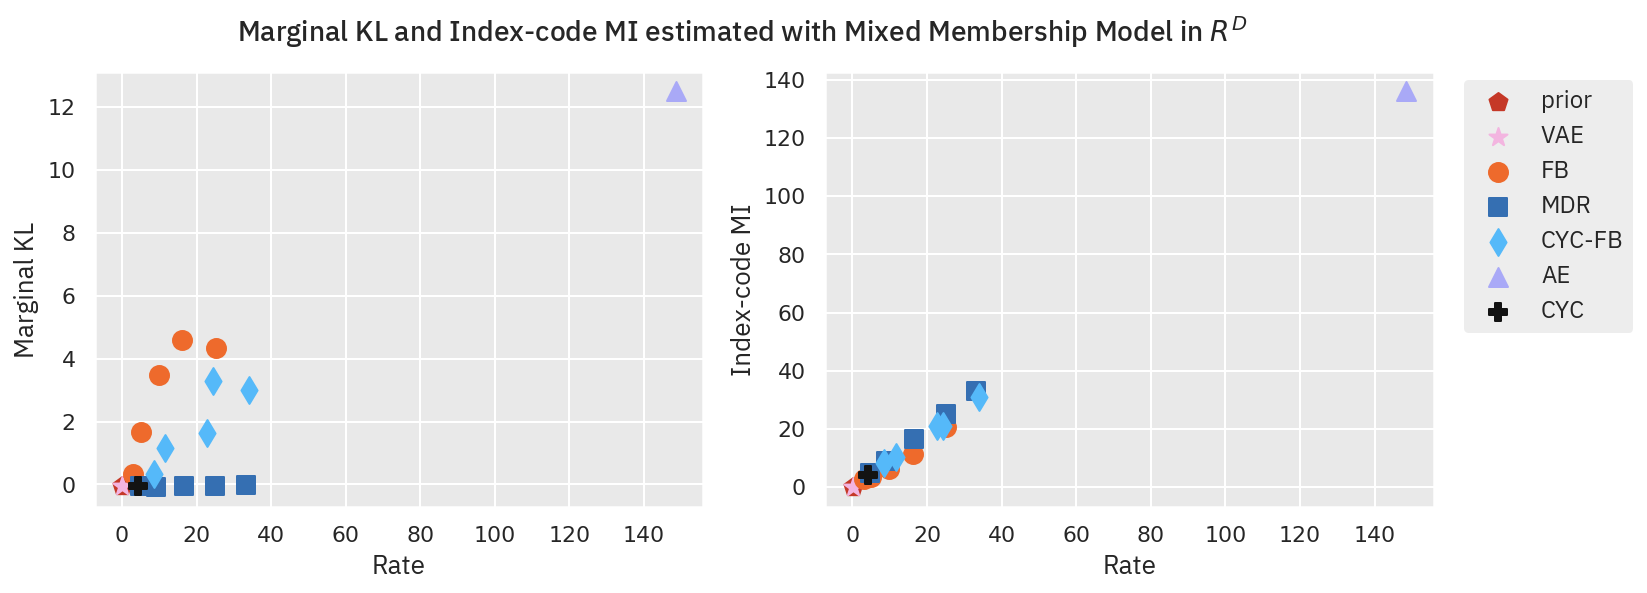

In [52]:
plt.rcParams["axes.grid"] = True

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

for n, v in estimates.items():
    #print(v["target_rate"], v["marginal_kl"])
    
    if (v["target_rate"] == 0.0) or (v["target_rate"] == 0.125) :
        label = v["optimisation"]
    else:
        label = None
    s = 90 if opt_techniques[g] in ["VAE", "CYC", "prior"] else 40
    axs[0].scatter(v["rate"], v["marginal_kl"], label=label, color=opt_c_dict[v["optimisation"]],
                  marker=marker_dict[v["optimisation"]], s=s, edgecolors=None)

plt.sca(axs[0])
plt.xticks(fontproperties=get_font_prop("regular"))
plt.yticks(fontproperties=get_font_prop("regular"))
axs[0].set_ylabel("Marginal KL", fontproperties=get_font_prop("regular"), size=13)
axs[0].set_xlabel("Rate", fontproperties=get_font_prop("regular"), size=13)
# axs[0].set_title("Marginal KL estimated with Mixed Membership Model in $R^D$")
#plt.savefig("plots/Marginal-KL-Mixed_Membership-RD-Delta.png", dpi=300, bbox_inches="tight")

for n, v in estimates.items():
    #print(v["target_rate"], v["marginal_kl"])
    
    if (v["target_rate"] == 0.0) or (v["target_rate"] == 0.125) :
        label = v["optimisation"]
    else:
        label = None
    
    s = 90 if opt_techniques[g] in ["VAE", "CYC", "prior"] else 40
    axs[1].scatter(v["rate"], v["index_code_mi"], label=label, color=opt_c_dict[v["optimisation"]],
                   marker=marker_dict[v["optimisation"]], s=s, edgecolors=None)
    

plt.sca(axs[1])
plt.xticks(fontproperties=get_font_prop("regular"))
plt.yticks(fontproperties=get_font_prop("regular"))
axs[1].set_ylabel("Index-code MI", fontproperties=get_font_prop("regular"), size=13)
axs[1].set_xlabel("Rate", fontproperties=get_font_prop("regular"), size=13)
prop = get_font_prop("regular")
prop.set_size(12)
leg = plt.legend(loc=(1.05, 0.4), prop=prop)
leg.get_frame().set_linewidth(0.0)
# axs[1].set_title("Index-code MI estimated with Mixed Membership Model in $R^D$")

plt.suptitle("Marginal KL and Index-code MI estimated with Mixed Membership Model in $R^D$", 
             fontproperties=get_font_prop("medium"), size=14)
plt.savefig("plots/marginal_kl_mi_MMM_RD.png", dpi=300, bbox_inches="tight")
plt.show()

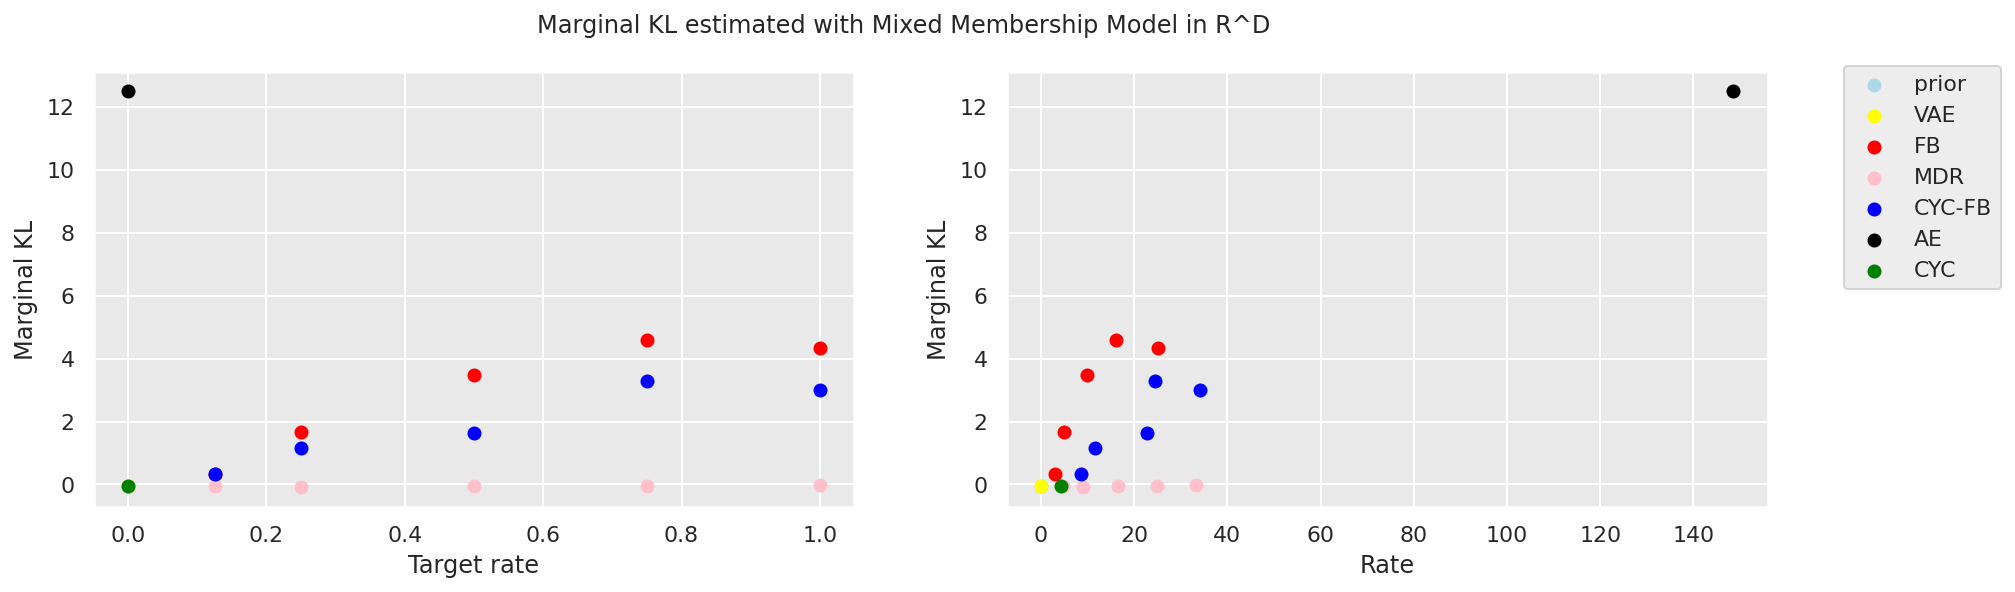

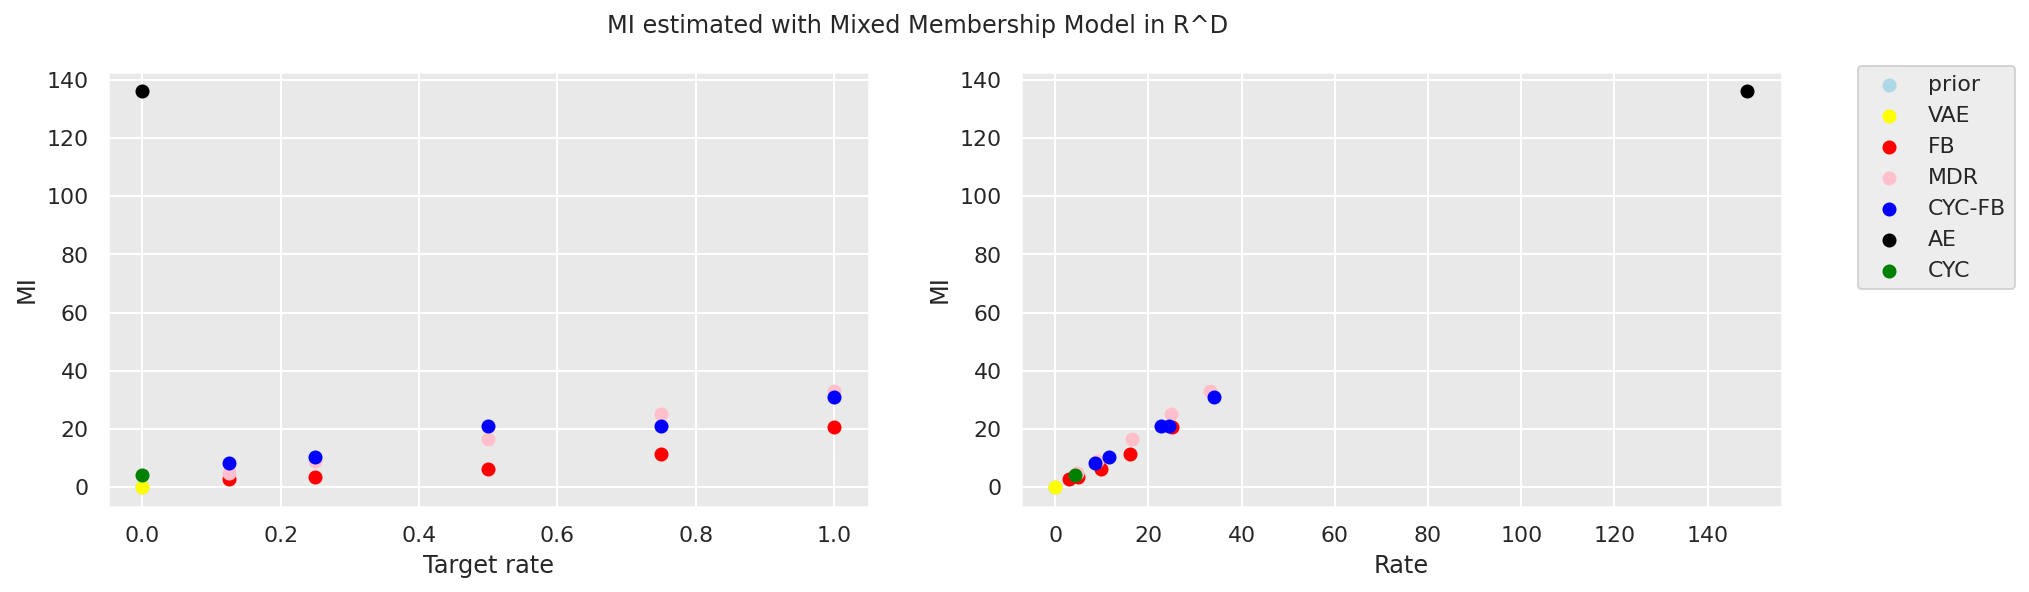

In [48]:
# colors = ['blue', 'green', 'pink', 'red', 'yellow', 'lightblue', 'black']
# c_dict = {o:colors[i] for i, o in enumerate(list(set(opt_techniques)))}
    
# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))

# for n, v in estimates.items():
#     #print(v["target_rate"], v["marginal_kl"])
    
#     if (v["target_rate"] == 0.0) or (v["target_rate"] == 0.125) :
#         axs[0].scatter(v["target_rate"], v["marginal_kl"], label=v["optimisation"], color=c_dict[v["optimisation"]])
#     else:
#         axs[0].scatter(v["target_rate"], v["marginal_kl"], color=c_dict[v["optimisation"]])
        
#     if (v["target_rate"] == 0.0) or (v["target_rate"] == 0.125) :
#         axs[1].scatter(v["rate"], v["marginal_kl"], label=v["optimisation"], color=c_dict[v["optimisation"]])
#     else:
#         axs[1].scatter(v["rate"], v["marginal_kl"], color=c_dict[v["optimisation"]])

# axs[0].set_ylabel("Marginal KL")
# axs[1].set_ylabel("Marginal KL")
# axs[0].set_xlabel("Target rate")
# axs[1].set_xlabel("Rate")
# axs[1].legend(loc=(1.1, 0.5))

# plt.suptitle("Marginal KL estimated with Mixed Membership Model in R^D")
# plt.savefig("plots/Marginal-KL-Mixed_Membership-RD-Delta.png", dpi=300, bbox_inches="tight")
# plt.show()

# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))

# for n, v in estimates.items():
#     if (v["target_rate"] == 0.0) or (v["target_rate"] == 0.125) :
#         axs[0].scatter(v["target_rate"], v["index_code_mi"], label=v["optimisation"], color=c_dict[v["optimisation"]])
#     else:
#         axs[0].scatter(v["target_rate"], v["index_code_mi"], color=c_dict[v["optimisation"]])
        
#     if (v["target_rate"] == 0.0) or (v["target_rate"] == 0.125) :
#         axs[1].scatter(v["rate"], v["index_code_mi"], label=v["optimisation"], color=c_dict[v["optimisation"]])
#     else:
#         axs[1].scatter(v["rate"], v["index_code_mi"], color=c_dict[v["optimisation"]])


# axs[0].set_ylabel("MI")
# axs[1].set_ylabel("MI")
# axs[0].set_xlabel("Target rate")
# axs[1].set_xlabel("Rate")
# axs[1].legend(loc=(1.1, 0.5))

# plt.suptitle("MI estimated with Mixed Membership Model in R^D")
# # plt.savefig("plots/MI-Mixed_Membership-RD-Delta.png", dpi=300, bbox_inches="tight")
# plt.show()

In [ ]:
z = td.Categorical(probs=omega).sample()
z.shape

In [ ]:
_ = plt.hist(z.detach().cpu().numpy(), bins=cfg.T+1)

In [ ]:
post_mu = (posterior["mu"] *  torch.nn.functional.one_hot(z, cfg.T).unsqueeze(-1)).sum(-2)  #[z].shape
post_mu.shape

In [ ]:
post_diag = (posterior["diag"] *  torch.nn.functional.one_hot(z, cfg.T).unsqueeze(-1)).sum(-2)  #[z].shape
post_diag.shape

In [ ]:
post_C = (posterior["C"] *  torch.nn.functional.one_hot(z, cfg.T).unsqueeze(-1).unsqueeze(-1)).sum(-3)  #[z].shape
post_C.shape

In [ ]:
import arviz

In [ ]:
posterior['mu'].squeeze(1).shape

In [ ]:
arviz.plot_forest(
    post_mu.permute([2, 0, 1]).reshape(1, -1, G).detach().cpu().numpy()
    #posterior['mu'].squeeze(1).permute([2, 0, 1]).detach().cpu().numpy()
    #kind='ridgeplot'
)

In [ ]:
arviz.plot_forest(
    post_diag.permute([2, 0, 1]).reshape(1, -1, G).detach().cpu().numpy()    
)

In [ ]:
arviz.plot_forest(
    post_C.permute([3, 0, 2, 1]).reshape(1, -1, G).detach().cpu().numpy()    
)